# Coupling Pathways 
In Chapter 10 we formulated a mass-action stoichiometric simulation (MASS) model of glycolysis. We took a linear pathway and converted it into an open system with defined inputs and outputs, formed the dynamic mass balances, and then simulated its response to increased rate of energy use. In this chapter, we will show how one can build a dynamic simulation model for two coupled pathways that is based on an integrated stoichiometric scaffold for the two pathways. We start with the pentose pathway and then couple it to the glycolytic model from Chapter 10 to form a simulation model of two pathways to study their simultaneous dynamic responses. 

**MASSpy** will be used to demonstrate some of the topics in this chapter.

In [1]:
from mass import (
    MassModel, MassMetabolite, MassReaction,
    Simulation, MassSolution, strip_time)
from mass.test import create_test_model
from mass.util.matrix import nullspace, left_nullspace, matrix_rank
from mass.visualization import (
    plot_time_profile, plot_phase_portrait, plot_tiled_phase_portraits,
    plot_comparison)

Other useful packages are also imported at this time.

In [2]:
from os import path

from cobra import DictList
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym

Some options and variables used throughout the notebook are also declared here.

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.3f}'.format
S_FONT = {"size": "small"}
L_FONT = {"size": "large"}
INF = float("inf")

/Users/zhaiman/opt/miniconda3/envs/masspy-dev-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3 FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## The Pentose Phosphate Pathway  
### Defining the system  
The pentose phosphate pathway (PPP) originates from G6P in glycolysis. The pathway is typically thought of as being comprised of two parts: the oxidative and the non-oxidative branches. 

![Figure-11-1](../../media/SB2/Ch11/Figure-11-1.png)

**Figure 11.1:** The pentose pathway. The reaction schema, cofactor interactions, and environmental exchanges.

In [4]:
ppp = create_test_model("SB2_PentosePhosphatePathway")

### The oxidative branch  
G6P undergoes two oxidation steps including decarboxylation, releasing $\text{CO}_2$, leading to the formation of one pentose and two NADPH molecules. These reactions are called the _oxidative branch_ of the pentose pathway. The branch forms two NADPH molecules that are used to form glutathione (GSH) from an oxidized dimeric state, GSSG, by breaking a di-sulfite bond. GSH and GSSG are present in high concentrations, and thus buffer the NADPH redox charge (recall the discussion of the creatine phosphate buffer in Chapter 8). The pentose formed, R5P, can be used for biosynthesis. We will discuss the connection of R5P with the salvage pathways in Chapter 12. 

### The non-oxidative branch  
If the pentose formed by the oxidative branch is not used for biosynthetic purposes, it undergoes a number of isomerization, epimerisation, transaldolation, and transketolation reactions that lead to the formation of F6P and GAP. Specifically, two F6P and one GAP that return to glycolysis come from three pentose molecules (i.e., $3*5=15$ carbon atoms go to $2*6+3=15$ carbon atoms). This part of the pathway is the _non-oxidative branch,_ and it is comprised of a series of reversible reactions, while the oxidative branch is irreversible. The non-oxidative branch can operate in either direction depending on the cell's physiological state.

### The overall reaction schema  
When no pentose  is used by other pathways, the overall flow of carbon in the pentose phosphate pathway can be described by 

$$\begin{equation} 3\ \text{G6P}\rightarrow 2\ \text{F6P} + \text{GAP} +3\ \text{CO}_2 \tag{11.1} \end{equation}$$

The input and output from the pathway are glycolytic intermediates. Two redox equivalents of NADPH (or GSH) are produced for every G6P that enters the pathway. 

### Metabolic functions  
The function of the pentose pathway is to produce redox potential in the form of NADPH and a pentose phosphate that is used for nucleotide synthesis. Also, a 4-carbon intermediate, E4P, is used as a biosynthetic precursor for amino acid synthesis. Exchange reactions for R5P and E4P can then be added to complete the system, as well as a redox load on NADPH. 

### The biochemical reactions  
The pentose phosphate pathway has twelve compounds (Table 11.1). The pathway has eleven reactions given in (Table 11.2). Their elemental composition is given in Table 11.3. The charge balance is given in Table 11.4.  We will consider the removal of R5P, but not of E4P, in this chapter. An exchange reaction for E4P can be added if desired, see the homework section for this chapter.

**Table 11.1:** Pentose pathway intermediates, their abbreviations, and steady state concentrations for the parameter values used in this chapter. The concentrations given are those for the human red blood cell. The index on the compounds is added to that for glycolysis, Table 10.1*

In [5]:
metabolite_ids = [m.id for m in ppp.metabolites
                  if m.id not in ["f6p_c", "g6p_c", "g3p_c", "h_c", "h2o_c"]]

table_11_1 = pd.DataFrame(
    np.array([metabolite_ids,
              [met.name for met in ppp.metabolites 
               if met.id in metabolite_ids],
              [ppp.initial_conditions[met] for met in ppp.metabolites 
               if met.id in metabolite_ids]]).T,
    index=[i for i in range(21, len(metabolite_ids) + 21)],
    columns=["Abbreviations", "Species", "Initial Concentration"])
table_11_1

Abbreviations                                                Species  \
21  _6pgl_c       6-Phospho-D-gluco-1,5-lactone                           
22  _6pgc_c       6-Phospho-D-gluconate                                   
23  ru5p__D_c     D-Ribulose 5-phosphate                                  
24  xu5p__D_c     D-Xylulose 5-phosphate                                  
25  r5p_c         Alpha-D-Ribose 5-phosphate                              
26  s7p_c         Sedoheptulose 7-phosphate                               
27  e4p_c         D-Erythrose 4-phosphate                                 
28  nadp_c        Nicotinamide adenine dinucleotide phosphate             
29  nadph_c       Nicotinamide adenine dinucleotide phosphate - reduced   
30  gthrd_c       Reduced glutathione                                     
31  gthox_c       Oxidized glutathione                                    
32  co2_c         CO2                                                     

   Initial Concentration  
21  0.00175424            
22  0.0374753             
23  0.00493679            
24  0.0147842             
25  0.0126689             
26  0.023988              
27  0.00507507            
28  0.0002                
29  0.0658                
30  3.2                   
31  0.12                  
32  1

**Table 11.2:** Pentose pathway enzymes and transporters, their abbreviations and chemical reactions. The reactions of the oxidative branch are irreversible, while those of the non-oxidative branch are reversible.

In [6]:
reaction_ids = [r.id for r in ppp.reactions 
                if r.id not in ["SK_g6p_c", "DM_f6p_c", "DM_g3p_c", 
                                "DM_r5p_c", "SK_h_c", "SK_h2o_c"]]
table_11_2 = pd.DataFrame(
    np.array([reaction_ids,
              [r.name for r in ppp.reactions
               if r.id in reaction_ids],
              [r.reaction for r in ppp.reactions
               if r.id in reaction_ids]]).T,
    index=[i for i in range(22, len(reaction_ids) + 22)],
    columns=["Abbreviations", "Enzymes/Transporter/Load", "Elementally Balanced Reaction"])
table_11_2

Abbreviations           Enzymes/Transporter/Load  \
22  G6PDH2r       Glucose 6-phosphate dehydrogenase   
23  PGL           6-phosphogluconolactonase           
24  GND           Phosphogluconate dehydrogenase      
25  RPE           Ribulose 5-phosphate 3-epimerase    
26  RPI           Ribulose 5-Phosphate Isomerase      
27  TKT1          Transketolase                       
28  TKT2          Transketolase                       
29  TALA          Transaldolase                       
30  GTHOr         Glutathione oxidoreductase          
31  GSHR          Glutathione-disulfide reductase     
32  SK_co2_c      CO2 sink                            

                       Elementally Balanced Reaction  
22  g6p_c + nadp_c <=> _6pgl_c + h_c + nadph_c        
23  _6pgl_c + h2o_c <=> _6pgc_c + h_c                 
24  _6pgc_c + nadp_c <=> co2_c + nadph_c + ru5p__D_c  
25  ru5p__D_c <=> xu5p__D_c                           
26  ru5p__D_c <=> r5p_c                               
27  r5p_c + xu5p__D_c <=> g3p_c + s7p_c               
28  e4p_c + xu5p__D_c <=> f6p_c + g3p_c               
29  g3p_c + s7p_c <=> e4p_c + f6p_c                   
30  gthox_c + h_c + nadph_c <=> 2 gthrd_c + nadp_c    
31  2 gthrd_c <=> gthox_c + 2 h_c                     
32  co2_c <=>

**Table 11.3:** The elemental composition and charges of the pentose phosphate pathway intermediates. This table represents the matrix $\textbf{E}.$*

In [7]:
table_11_3 = ppp.get_elemental_matrix(array_type="DataFrame", 
                                      dtype=np.int64)
table_11_3

f6p_c  g6p_c  g3p_c  _6pgl_c  _6pgc_c  ru5p__D_c  xu5p__D_c  r5p_c  \
C       6      6      3      6        6        5          5          5       
H       11     11     5      9        10       9          9          9       
O       9      9      6      9        10       8          8          8       
P       1      1      1      1        1        1          1          1       
N       0      0      0      0        0        0          0          0       
S       0      0      0      0        0        0          0          0       
q      -2     -2     -2     -2       -3       -2         -2         -2       
[NADP]  0      0      0      0        0        0          0          0       

        s7p_c  e4p_c  nadp_c  nadph_c  gthrd_c  gthox_c  co2_c  h_c  h2o_c  
C       7      4      21      21       10       20       1      0    0      
H       13     7      25      26       16       30       0      1    2      
O       10     7      17      17       6        12       2      0    1      
P       1      1      3       3        0        0        0      0    0      
N       0      0      7       7        3        6        0      0    0      
S       0      0      0       0        1        2        0      0    0      
q      -2     -2     -3      -4       -1       -2        0      1    0      
[NADP]  0      0      1       1        0        0        0      0    0

**Table 11.4:** The elemental and charge balance test on the reactions. All internal reactions are balanced.  Exchange reactions are not. Note that the GSHR exchange reaction creates two electrons. This corresponds to the delivery of two electrons to the compound or process that uses redox potential.

In [8]:
table_11_4 = ppp.get_elemental_charge_balancing(array_type="DataFrame", 
                                                dtype=np.int64)
table_11_4

G6PDH2r  PGL  GND  RPE  RPI  TKT1  TKT2  TALA  GTHOr  GSHR  SK_g6p_c  \
C       0        0    0    0    0    0     0     0     0      0     6          
H       0        0    0    0    0    0     0     0     0      0     11         
O       0        0    0    0    0    0     0     0     0      0     9          
P       0        0    0    0    0    0     0     0     0      0     1          
N       0        0    0    0    0    0     0     0     0      0     0          
S       0        0    0    0    0    0     0     0     0      0     0          
q       0        0    0    0    0    0     0     0     0      2    -2          
[NADP]  0        0    0    0    0    0     0     0     0      0     0          

        DM_f6p_c  DM_g3p_c  DM_r5p_c  SK_co2_c  SK_h_c  SK_h2o_c  
C      -6        -3        -5        -1         0       0         
H      -11       -5        -9         0        -1      -2         
O      -9        -6        -8        -2         0      -1         
P      -1        -1        -1         0         0       0         
N       0         0         0         0         0       0         
S       0         0         0         0         0       0         
q       2         2         2         0        -1       0         
[NADP]  0         0         0         0         0       0

Table 11.4 shows that $\textbf{ES} = 0$ for all non-exchange reactions in the pentose phosphate pathway model. Thus the reactions are charge and elementally balanced.  The model passes this QC/QA test.

In [9]:
for boundary in ppp.boundary:
    print(boundary)

SK_g6p_c:  <=> g6p_c
DM_f6p_c: f6p_c --> 
DM_g3p_c: g3p_c --> 
DM_r5p_c: r5p_c --> 
SK_co2_c: co2_c <=> 
SK_h_c: h_c <=> 
SK_h2o_c: h2o_c <=> 


### The pathway structure: basis for the null space
The null space is spanned by two vectors, $p_1$ and $p_2$, that have pathway interpretations as for glycolysis. They are graphically shown in Figure 11.2.

**Table 11.5:** The calculated MinSpan pathway vectors for the stoichiometric matrix for the glycolytic system.

In [10]:
reaction_ids = [r.id for r in ppp.reactions]
# MinSpan pathways are calculated outside this notebook and the results are provided here.
minspan_paths = np.array([
    [1, 1, 1, 2/3, 1/3, 1/3, 1/3, 1/3, 2, 2, 1, 2/3, 1/3, 0, 1, 4, -1],
    [1, 1, 1,  0,   1,   0,   0,   0,  2, 2, 1,  0,   0,  1, 1, 4, -1]])
# Round to the 3rd decimal point for minspan_paths
minspan_paths = np.array([[round(val, 3) for val in row] 
                          for row in minspan_paths])
# Create labels for the paths
path_labels = ["$p_1$","$p_2$"]
# Create DataFrame
table_11_5 = pd.DataFrame(minspan_paths, index=path_labels,
                          columns=reaction_ids)
table_11_5

G6PDH2r   PGL   GND   RPE   RPI  TKT1  TKT2  TALA  GTHOr  GSHR  \
$p_1$ 1.000    1.000 1.000 0.667 0.333 0.333 0.333 0.333 2.000  2.000   
$p_2$ 1.000    1.000 1.000 0.000 1.000 0.000 0.000 0.000 2.000  2.000   

       SK_g6p_c  DM_f6p_c  DM_g3p_c  DM_r5p_c  SK_co2_c  SK_h_c  SK_h2o_c  
$p_1$ 1.000     0.667     0.333     0.000     1.000     4.000   -1.000     
$p_2$ 1.000     0.000     0.000     1.000     1.000     4.000   -1.000

The pathways are biochemically interpreted as follows:

1. The first pathway describes the oxidative branch of the PPP to form one R5P and one CO2. Two redox equivalents in the form of GSH are made. 

2. The second pathway is the classical complete conversion of one G6P to 2/3 F6P and 1/3 GAP with the formation of two redox equivalents

![Figure-11-2](../../media/SB2/Ch11/Figure-11-2.png)

**Figure 11.2:** The two pathway vectors that span the null space of $\textbf{S}$ for the PPP as shown in Table 11.2.

### Elemental balancing of the pathway vectors  
Each of the pathway vectors needs to be elementally balanced, which means the elements coming into and leaving a pathway through the transporters need to be balanced. Thus we must have $\textbf{ESp}_i = 0$ for each pathway. This condition is satisfied for these two pathways. 

**Table 11.6:** Elemental and charge balancing on the MinSpan pathways of the Pentose Phosphate Pathway.

In [11]:
table_11_6 = ppp.get_elemental_charge_balancing(array_type="DataFrame").dot(minspan_paths.T).astype(np.int64)
table_11_6.columns = path_labels
table_11_6

$p_1$  $p_2$
C       0      0    
H       0      0    
O       0      0    
P       0      0    
N       0      0    
S       0      0    
q       0      0    
[NADP]  0      0

### The time invariant pools: the basis for the left null space  

The stoichiometric matrix has a left null space of dimension 2, meaning the pentose phosphate pathway as defined has two time invariant pools. These can be found in the _Left Nullspace_ of the pentose phosphate pathway model. We can compute them directly: 

**Table 11.7:** The left null space vectors of the stoichiometric matrix for the  Pentose Phosphate Pathway.

In [12]:
metabolite_ids = [m.id for m in ppp.metabolites]
lns = left_nullspace(ppp.S, rtol=1e-10)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])

# Row operations to find biologically meaningful pools
lns[1] = (-lns[1]*17 + lns[0])/120
lns[0] =(lns[1] - lns[0])/17
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Create labels for the time invariants
time_inv_labels = ["$NP_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$"]
table_11_7 = pd.DataFrame(lns, index=time_inv_labels,
                          columns=metabolite_ids, dtype=np.int64)
table_11_7

f6p_c  g6p_c  g3p_c  _6pgl_c  _6pgc_c  ru5p__D_c  \
$NP_{\mathrm{tot}}$  0      0      0      0        0        0           
$G_{\mathrm{tot}}$   0      0      0      0        0        0           

                     xu5p__D_c  r5p_c  s7p_c  e4p_c  nadp_c  nadph_c  gthrd_c  \
$NP_{\mathrm{tot}}$  0          0      0      0      1       1        0         
$G_{\mathrm{tot}}$   0          0      0      0      0       0        1         

                     gthox_c  co2_c  h_c  h2o_c  
$NP_{\mathrm{tot}}$  0        0      0    0      
$G_{\mathrm{tot}}$   2        0      0    0

$\textbf{1.}$ The first time invariant is the total amount of the NADP moiety

$\textbf{2.}$ The second time invariant is the total amount of the glutathione moiety, GS-.

### An 'annotated' form of the stoichiometric matrix  
All of the properties of the stoichiometric matrix can be conveniently summarized in a tabular format, Table 11.8. The table succinctly summarizes the chemical and topological properties of $\textbf{S}$. The matrix has dimensions of 17x17 and a rank of 15. It thus has a 2 dimensional null space and a two dimensional left null space.

**Table 11.8:** The stoichiometric matrix for the Pentose Phosphate Pathway seen in Figure 11.1. The matrix is partitioned to show the intermediates (yellow)  separate from the cofactors and to separate the exchange reactions and cofactor loads (orange). The connectivities, $\rho_i$(red), for a compound, and the participation number, $\pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the three pathway vectors (purple) for the pentose phosphate pathway. These vectors are graphically shown in Figure 11.2. Furthest to the right, we display the two time invariant pools (green) that span the left null space.

In [13]:
# Define labels
pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[NADP]']

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = ppp.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = ppp.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
table_11_8 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_11_8) - len(metabolite_ids))
rho = np.concatenate((rho, blanks))
time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_11_8 = np.vstack([table_11_8.T, rho, time_inv]).T

colors = {"intermediates": "#ffffe6", # Yellow
          "cofactors": "#ffe6cc",     # Orange
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
def highlight_table(df, model, main_shape):
    df = df.copy()
    n_mets, n_rxns = (len(model.metabolites), len(model.reactions))
    # Highlight rows
    for row in df.index:
        other_key, condition = ("blank", lambda i, v: v != "")
        if row == pi_str:        # For participation
            main_key = "pi"
        elif row in chopsnq:     # For elemental balancing
            main_key = "chopsnq"
        elif row in path_labels: # For pathways
            main_key = "pathways"
        else:
            # Distinguish between intermediate and cofactor reactions for model reactions
            main_key, other_key = ("cofactors", "intermediates")            
            condition = lambda i, v: (main_shape[1] <= i and i < n_rxns)
        df.loc[row, :] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else bg_color_str + colors[other_key] 
                          for i, v in enumerate(df.loc[row, :])]

    for col in df.columns:
        condition = lambda i, v: v != bg_color_str + colors["blank"]
        if col == rho_str:
            main_key = "rho"
        elif col in time_inv_labels:
            main_key = "time_invs"
        else:
            # Distinguish intermediates and cofactors for model metabolites
            main_key = "cofactors"
            condition = lambda i, v: (main_shape[0] <= i and i < n_mets)
        df.loc[:, col] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else v for i, v in enumerate(df.loc[:, col])]
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_11_8 = pd.DataFrame(
    table_11_8, index=index_labels, columns=column_labels)
# Apply colors
table_11_8 = table_11_8.style.apply(
    highlight_table,  model=ppp, main_shape=(10, 10), axis=None)
table_11_8

### The steady state
If we fix the flux into the pathway, $v_{SK_{G6P}}$, and the exit flux of R5P, $v_{DM_{R5P}}$, then we fix the steady state flux distribution since these fluxes uniquely specify the pathway fluxes. We set these numbers at 0.21 mM/hr and 0.01 mM/hr, respectively. The former value represents a typical flux through the pentose pathway while the latter will couple at a low flux level to the AMP pathways treated in the next chapter. Using $\textbf{p}_1 + \textbf{p}_2=0.21$ and $\textbf{p}_1=0.01$ we can compute the steady state. 

In [14]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    ppp.reactions.SK_g6p_c: 0.21, 
    ppp.reactions.DM_r5p_c: 0.01}

# Compute steady state fluxes
ssfluxes = ppp.compute_steady_state_fluxes(
    minspan_paths, 
    independent_fluxes,
    update_reactions=True)

table_11_9 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids, 
                          columns=[r"$\textbf{v}_{\mathrm{stst}}$"]).T

**Table 11.9:** Computing the steady state fluxes as a summation of the MinSpan pathway vectors.

In [15]:
table_11_9

G6PDH2r   PGL   GND   RPE   RPI  TKT1  TKT2  \
$\textbf{v}_{\mathrm{stst}}$ 0.210    0.210 0.210 0.133 0.077 0.067 0.067   

                              TALA  GTHOr  GSHR  SK_g6p_c  DM_f6p_c  DM_g3p_c  \
$\textbf{v}_{\mathrm{stst}}$ 0.067 0.420  0.420 0.210     0.133     0.067       

                              DM_r5p_c  SK_co2_c  SK_h_c  SK_h2o_c  
$\textbf{v}_{\mathrm{stst}}$ 0.010     0.210     0.840   -0.210

and can be visualized as a bar chart:

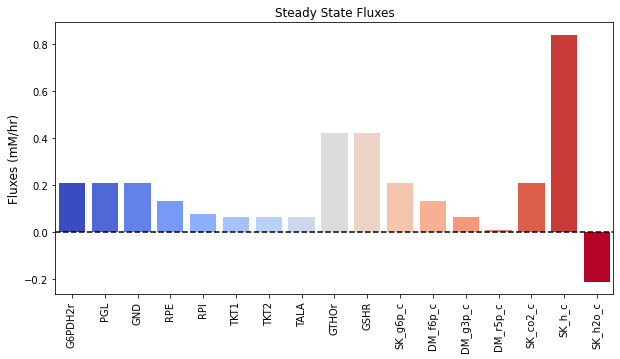

In [16]:
fig_11_3, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, list(ssfluxes.values()), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)]);
# Set labels and adjust ticks
ax.set_xticks(indicies);
ax.set_xticklabels(reaction_ids, rotation="vertical");
ax.set_ylabel("Fluxes (mM/hr)", L_FONT);
ax.set_title("Steady State Fluxes", L_FONT);
# Add a dashed line at 0 
ax.plot([0, len(reaction_ids)], [0, 0], "k--");

**Figure 11.3:** Bar chart of the steady-state fluxes.

We can perform a numerical check make sure that we have a steady state flux vector by performing the multiplication $\textbf{Sv}_{\mathrm{stst}}$ that should yield zero.

**A numerical QC/QA:** Ensure $\textbf{Sv}_{\mathrm{stst}} = 0$

In [17]:
pd.DataFrame(
    ppp.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"],
    dtype=np.int64).T

f6p_c  g6p_c  g3p_c  _6pgl_c  _6pgc_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0      0      0      0        0         

                               ru5p__D_c  xu5p__D_c  r5p_c  s7p_c  e4p_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0          0          0      0      0       

                               nadp_c  nadph_c  gthrd_c  gthox_c  co2_c  h_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0       0        0        0        0      0     

                               h2o_c  
$\textbf{Sv}_{\mathrm{stst}}$  0

### Computing the PERCs  
The approximate steady state values of the metabolites are given above. The mass action ratios can be computed from these steady state concentrations.  We can also compute the forward rate constant for the reactions:

In [18]:
percs = ppp.calculate_PERCs(update_reactions=True)

**Table 11.10:** Pentose phosphate pathway enzymes, loads, transport rates, and their abbreviations. For irreversible reactions, the numerical value for the equilibrium constants is $\infty$, which, for practical reasons, can be set to a finite value.

In [19]:
# Get concentration values for substitution into sympy expressions
value_dict = {sym.Symbol(str(met)): ic 
              for met, ic in ppp.initial_conditions.items()}
value_dict.update({sym.Symbol(str(met)): bc 
                   for met, bc in ppp.boundary_conditions.items()})

table_11_10 = []
# Get symbols and values for table and substitution
for p_key in ["Keq", "kf"]:
    symbol_list, value_list = [], []
    for p_str, value in ppp.parameters[p_key].items():
        symbol_list.append(r"$%s_{\text{%s}}$" % (p_key[0], p_str.split("_", 1)[-1]))
        value_list.append("{0:.3f}".format(value) if value != INF else r"$\infty$")
        value_dict.update({sym.Symbol(p_str): value})
    table_11_10.extend([symbol_list, value_list])

table_11_10.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(ppp.get_mass_action_ratios()).values()])
table_11_10.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(ppp.get_disequilibrium_ratios()).values()])
table_11_10 = pd.DataFrame(np.array(table_11_10).T, index=reaction_ids,
                           columns=[r"$K_{eq}$ Symbol", r"$K_{eq}$ Value", "PERC Symbol", 
                                    "PERC Value", r"$\Gamma$", r"$\Gamma/K_{eq}$"])
table_11_10

$K_{eq}$ Symbol $K_{eq}$ Value            PERC Symbol  \
G6PDH2r   $K_{\text{G6PDH2r}}$   1000.000       $k_{\text{G6PDH2r}}$    
PGL       $K_{\text{PGL}}$       1000.000       $k_{\text{PGL}}$        
GND       $K_{\text{GND}}$       1000.000       $k_{\text{GND}}$        
RPE       $K_{\text{RPE}}$       3.000          $k_{\text{RPE}}$        
RPI       $K_{\text{RPI}}$       2.570          $k_{\text{RPI}}$        
TKT1      $K_{\text{TKT1}}$      1.200          $k_{\text{TKT1}}$       
TKT2      $K_{\text{TKT2}}$      10.300         $k_{\text{TKT2}}$       
TALA      $K_{\text{TALA}}$      1.050          $k_{\text{TALA}}$       
GTHOr     $K_{\text{GTHOr}}$     100.000        $k_{\text{GTHOr}}$      
GSHR      $K_{\text{GSHR}}$      2.000          $k_{\text{GSHR}}$       
SK_g6p_c  $K_{\text{SK_g6p_c}}$  1.000          $k_{\text{SK_g6p_c}}$   
DM_f6p_c  $K_{\text{DM_f6p_c}}$  $\infty$       $k_{\text{DM_f6p_c}}$   
DM_g3p_c  $K_{\text{DM_g3p_c}}$  $\infty$       $k_{\text{DM_g3p_c}}$   
DM_r5p_c  $K_{\text{DM_r5p_c}}$  $\infty$       $k_{\text{DM_r5p_c}}$   
SK_co2_c  $K_{\text{SK_co2_c}}$  1.000          $k_{\text{SK_co2_c}}$   
SK_h_c    $K_{\text{SK_h_c}}$    1.000          $k_{\text{SK_h_c}}$     
SK_h2o_c  $K_{\text{SK_h2o_c}}$  1.000          $k_{\text{SK_h2o_c}}$   

          PERC Value    $\Gamma$ $\Gamma/K_{eq}$  
G6PDH2r   21864.589   11.875411   0.011875        
PGL       122.323     21.362698   0.021363        
GND       29287.807   43.340651   0.043341        
RPE       15292.319   2.994699    0.998233        
RPI       10555.433   2.566222    0.998530        
TKT1      1594.356    0.932371    0.776976        
TKT2      1091.154    1.921130    0.186517        
TALA      843.772     0.575416    0.548015        
GTHOr     53.330      0.259372    0.002594        
GSHR      0.041       0.011719    0.005859        
SK_g6p_c  0.221       0.048600    0.048600        
DM_f6p_c  6.737       50.505051   0.000000        
DM_g3p_c  9.148       137.362637  0.000000        
DM_r5p_c  0.789       78.933451   0.000000        
SK_co2_c  100000.000  1.000000    1.000000        
SK_h_c    100000.000  0.882510    0.882510        
SK_h2o_c  100000.000  1.000000    1.000000

These estimates for the numerical values for the PERCs are shown in Table 11.10. These numerical values, along with the elementary form of the rate laws, complete the definition of the dynamic mass balances that can now be simulated. The steady state is specified in Table 11.9.

### Dynamic response: increased rate of R5P production  
One function of the pentose pathway is to provide R5P for biosynthesis. We thus simulate its response to an increased rate of R5P use. We increase the value of $k_{DM_{R5P}}$, ten-fold at time zero and simulate the response. The responses in best interpreted in terms overall flux balance on the pathway; Figure 11.4

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


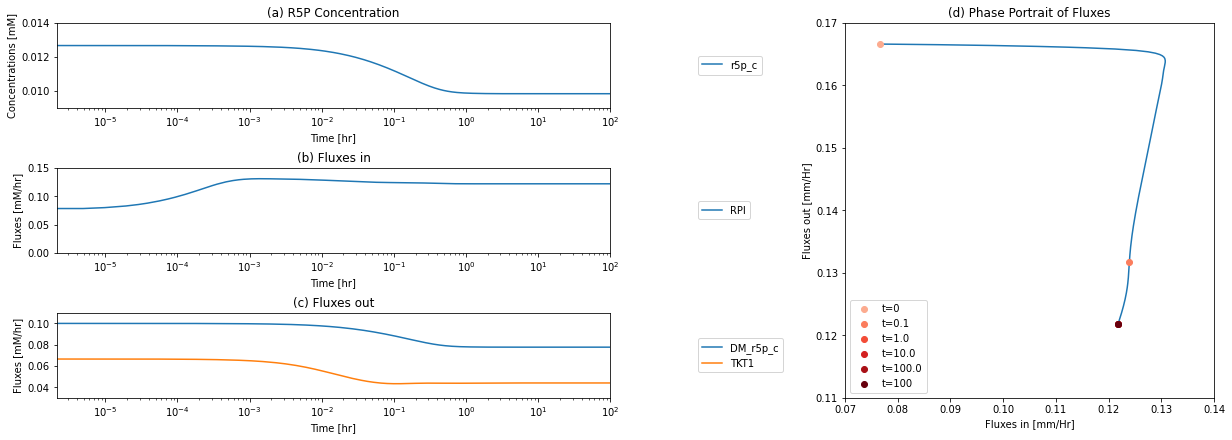

In [20]:
t0, tf = (0, 100)
sim_ppp = Simulation(ppp)
conc_sol, flux_sol = sim_ppp.simulate(
    ppp, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_DM_r5p_c": "kf_DM_r5p_c * 10"})

fig_11_4 = plt.figure(constrained_layout=True, figsize=(17, 6))
gs = fig_11_4.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_11_4.add_subplot(gs[0, 0])
ax2 = fig_11_4.add_subplot(gs[1, 0])
ax3 = fig_11_4.add_subplot(gs[2, 0])
ax4 = fig_11_4.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="r5p_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.009, 0.014),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) R5P Concentration", L_FONT));

fluxes_in = ["RPI"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf),  ylim=(0, .15), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["DM_r5p_c", "TKT1"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.03, .11),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(0.07, 0.14), ylim=(0.11, 0.17),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");

**Figure 11.4:** The time profiles of the (a) R5P concentration, (b) the fluxes that make R5P, (c) the fluxes that use R5P and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales).

The initial perturbation creates an imbalance on the R5P node as seen in Figure 11.4. These fluxes must balance in the steady state as indicated by the 45 degree line where the rate of formation and use balance, Figure 11.5a. Initially, $v_{DM_{R5P}}$ is instantaneously increased $(t = 0^+)$. The immediate response is a compensating increase of production by $v_{RPI}$, a rapidly equilibrating enzyme. The utilization of R5P by the non-oxidative branch then drops and steady state is reached to balance the increased removal rate of R5P from the system. 

The overall steady state flux balance states that the sum of the three fluxes leaving the network have to be balanced by the constant input of 0.21 mM/hr $(= v_{DM_{F6P}} + v_{DM_{G3P}} + v_{DM_{R5P}})$ as indicated by the -45 degree line in Figure 11.5b. Initially, $v_{DM_{R5P}}$ increases ten-fold. Over time, the return flux to glycolysis, $v_{DM_{F6P}} + v_{DM_{G3P}}$, decreases, until a steady state is reached. 

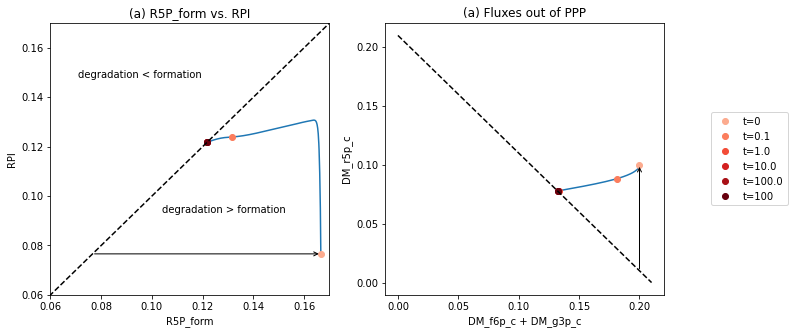

In [21]:
fig_11_5, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
(ax1, ax2) = axes.flatten()

R5P_form = ["DM_r5p_c", "TKT1"]
flux_out = ["DM_f6p_c", "DM_g3p_c"]


for flux_id, variables in zip(["R5P_form", "flux_out"],
                              [R5P_form, flux_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)

time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="R5P_form", y="RPI", ax=ax1,
    xlabel="R5P_form", ylabel="RPI", xlim=(.06, .17), ylim=(.06, .17),
    title=("(a) R5P_form vs. RPI", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors)

# Annotate the plot
ax1.plot([0, .24], [0, .24], "k--");
ax1.annotate("degradation < formation", xy=(.1, .8),
             xycoords="axes fraction")
ax1.annotate("degradation > formation", xy=(.4, .3),
             xycoords="axes fraction")
ax1.annotate("", xy=(flux_sol["R5P_form"][0], flux_sol["RPI"][0]),
             xytext=(ppp.reactions.TKT1.steady_state_flux + ppp.reactions.DM_r5p_c.steady_state_flux,
                     ppp.reactions.RPI.steady_state_flux),
             textcoords="data",
             arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

plot_phase_portrait(
    flux_sol, x="flux_out", y="DM_r5p_c", ax=ax2,
    xlabel="DM_f6p_c + DM_g3p_c", ylabel="DM_r5p_c",
    title=("(a) Fluxes out of PPP", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside")

# Annotate the plot
ax2.plot([0, 0.21], [.21 ,0], "k--")
ax2.annotate("", xy=(flux_sol["flux_out"][0], flux_sol["DM_r5p_c"][0]),
             xytext=(ppp.reactions.DM_f6p_c.steady_state_flux + ppp.reactions.DM_g3p_c.steady_state_flux,
                     ppp.reactions.DM_r5p_c.steady_state_flux),
             textcoords="data",
             arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

**Figure 11.5:**	Dynamic response of the pentose pathway, increasing the rate of R5P production. (a) The fluxes that form and degrade R5P, $v_{DM_{R5P}} + v_{TKT1}$ vs. $v_{RPI}$. (b) The fluxes out of the pentose pathway, $v_{DM_{F6P}} + v_{DM_{G3P}}$ vs.  $v_{DM_{R5P}}$.

## The Combined Stoichiometric Matrix  
### Coupling to glycolysis: forming a unified reaction map  
Since the inputs to and outputs from the pentose pathway are from glycolysis, the pentose pathway and glycolysis are readily interfaced to form a single reaction map (see Figure 11.6). The dashed arrows in the reaction map represent the return of F6P and GAP from the pentose pathway to glycolysis and do not represent actual reactions. The additional exchanges with the environment, over those in glycolysis alone, are $\text{CO}_2$ secretion and redox load on the NADPH pool, which are shown in Figure 11.6 as a load on GSH (reduced glutathione). We will not consider R5P production here. It will appear in the next chapter as it is involved in the nucleotide salvage pathways. 

![Figure-11-6](../../media/SB2/Ch11/Figure-11-6.png)

**Figure 11.6:** Coupling glycolysis and the pentose pathway. The reaction schema, cofactor interactions, and environmental exchanges.

### Joining the models
First, load both models. The pentose phosphate pathway is already loaded, so only the glycolysis model must be loaded:

In [22]:
glycolysis = create_test_model("SB2_Glycolysis")

To merge two models, we use the `MassModel.merge` method to merge the two pathways and get rid of redundant reactions. Models take precedence from left to right in terms of parameters, initial conditions, and other model attributes.

In [23]:
fullppp = glycolysis.merge(ppp, inplace=False)
fullppp.id = "Full_PPP_Model"

Ignoring reaction 'SK_h_c' since it already exists.
Ignoring reaction 'SK_h2o_c' since it already exists.


A few obsolete exchange reactions have to be removed.

In [24]:
for boundary in fullppp.boundary:
    print(boundary)

DM_amp_c: amp_c --> 
SK_pyr_c: pyr_c <=> 
SK_lac__L_c: lac__L_c <=> 
SK_glc__D_c:  <=> glc__D_c
SK_amp_c:  <=> amp_c
SK_h_c: h_c <=> 
SK_h2o_c: h2o_c <=> 
SK_g6p_c:  <=> g6p_c
DM_f6p_c: f6p_c --> 
DM_g3p_c: g3p_c --> 
DM_r5p_c: r5p_c --> 
SK_co2_c: co2_c <=> 


We can remove them using the `MassModel.remove_reactions` method.

In [25]:
fullppp.remove_reactions([
    r for r in fullppp.boundary 
    if r.id in ["SK_g6p_c", "DM_f6p_c", "DM_g3p_c", "DM_r5p_c"]])
fullppp.remove_boundary_conditions([
    "g6p_c", "f6p_c", "g3p_c", "r5p_c"])

The merged model contains 32 metabolites and 32 reactions:

In [26]:
print(fullppp.S.shape)

(32, 32)


The merged model is not in a steady-state since the flux through PGI has not been corrected for the flux (0.21) that was diverted into the PPP.  The PGI flux was 1.12 in the glycolytic model, and will need to be adjusted in the merged **fullppp** model.

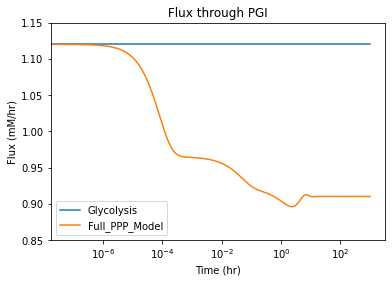

In [27]:
t0, tf = (0, 1e3)

fig_11_7, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

for model in [glycolysis, fullppp]:
    sim = Simulation(model)
    flux_sol = sim.simulate(model, time=(t0, tf, tf*10 + 1))[1]
    plot_time_profile(
        flux_sol, observable=["PGI"], ax=ax, 
        legend=model.id, plot_function="semilogx", 
        xlabel="Time (hr)", ylabel="Flux (mM/hr)", ylim=(0.85, 1.15),
        title=("Flux through PGI", L_FONT))

### Organization of the stoichiometric matrix

When the models are merged, metabolites and reactions are added at the end of their respecitive lists. We can perform a set of transformations to group the species and reactions into organized groups.  

In [28]:
# Define new order for metabolites
new_metabolite_order = ["glc__D_c", "g6p_c", "f6p_c", "fdp_c", "dhap_c", 
                        "g3p_c", "_13dpg_c", "_3pg_c", "_2pg_c", "pep_c", 
                        "pyr_c", "lac__L_c", "nad_c", "nadh_c", "amp_c", 
                        "adp_c", "atp_c", "pi_c", "h_c", "h2o_c", "_6pgl_c", "_6pgc_c", 
                        "ru5p__D_c", "xu5p__D_c", "r5p_c", "s7p_c", "e4p_c",
                        "nadp_c", "nadph_c", "gthrd_c", "gthox_c", "co2_c"]
if len(fullppp.metabolites) == len(new_metabolite_order):
    fullppp.metabolites = DictList(fullppp.metabolites.get_by_any(new_metabolite_order))
# Define new order for reactions
new_reaction_order = ["HEX1", "PGI", "PFK", "FBA", "TPI", 
                      "GAPD", "PGK", "PGM", "ENO", "PYK", 
                      "LDH_L", "DM_amp_c", "ADK1", "SK_pyr_c", 
                      "SK_lac__L_c", "ATPM", "DM_nadh", "SK_glc__D_c", 
                      "SK_amp_c", "SK_h_c", "SK_h2o_c",
                      "G6PDH2r", "PGL", "GND", "RPE", "RPI", 
                      "TKT1", "TKT2", "TALA", "GTHOr", "GSHR", "SK_co2_c"]
if len(fullppp.reactions) == len(new_reaction_order):
    fullppp.reactions = DictList(fullppp.reactions.get_by_any(new_reaction_order))

The stoichiometric matrix for glycolysis (Table 10.8) can be appended with the reactions in the pentose pathway (Table 11.1). The resulting stoichiometric matrix is shown in Table 11.11. This matrix has dimensions of 32x32 and its rank is 28. The null is of dimension 4 (=32-28) and the left null space is of dimension 4 (=32-28). The matrix is elementally balanced. 

We have used colors in Table 11.11 to illustrate the structure of the matrix. The two blocks of matrices on the diagonal are those for each pathway. The lower left block is filled with zero elements showing that the pentose pathway intermediates do not appear in glycolysis. Conversely, the upper right hand block shows that three of the glycolytic intermediates leave (GAP and F6P) and enter (G6P) the pentose pathway. Both glycolysis and the pentose pathway produce and/or consume protons and water. 

**Table 11.11:** The stoichiometric matrix for the coupled glycolytic and pentose pathways in Figure 11.6. The matrix is partitioned to show the glycolytic reactions (yellow)  separate from the pentose phosphate pathway (light blue). The connectivities, $\rho_i$ (red), for a compound, and the participation number, $pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the four pathway vectors (purple) for the merged model.  These vectors are graphically shown in Figure 11.10. Furthest to the right, we display the time invariant pools (green) that span the left null space.

In [29]:
# Define labels
metabolite_ids = [m.id for m in fullppp.metabolites]
reaction_ids = [r.id for r in fullppp.reactions]

pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[NAD]', '[NADP]']
time_inv_labels = [
    "$P_{\mathrm{tot}}$", "$N_{\mathrm{tot}}$",
    "$NP_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$"]
path_labels = ["$p_1$","$p_2$", "$p_3$", "$p_4$"]

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = fullppp.update_S(array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = fullppp.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1,-1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1,-2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,13,-3, 3, 3, 3, 2, 1, 1, 1, 1, 6, 6, 3]])

table_11_11 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_11_11) - len(fullppp.metabolites))
rho = np.concatenate((rho, blanks))

lns = np.array([
    [0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0],
])


time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_11_11 = np.vstack([table_11_11.T, rho, time_inv]).T

colors = {"glycolysis": "#ffffe6",    # Yellow
          "ppp": "#e6faff",           # Light blue
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
def highlight_table(df, model):
    df = df.copy()
    n_mets, n_rxns = (len(model.metabolites), len(model.reactions))
    # Highlight rows
    for row in df.index:
        other_key, condition = ("blank", lambda v, row: v != "")
        if row == pi_str:        # For participation
            main_key = "pi"
        elif row in chopsnq:     # For elemental balancing
            main_key = "chopsnq"
        elif row in path_labels: # For pathways
            main_key = "pathways"
        else:
            # Distinguish between reactions for model modules
            main_key, other_key = ("glycolysis", "ppp")            
            condition = lambda v, row: row in glycolysis.metabolites
        df.loc[row, :] = [bg_color_str + colors[main_key] if condition(v, row) 
                          else bg_color_str + colors[other_key] 
                          for v in df.loc[row, :]]

    for col in df.columns:
        condition = lambda i, v, col: v != bg_color_str + colors["blank"]
        if col == rho_str:
            main_key = "rho"
        elif col in time_inv_labels:
            main_key = "time_invs"
        else:
            # Distinguish between metabolites for model modules
            main_key = "ppp"
            condition = lambda i, v, col: (col not in glycolysis.reactions and i < n_mets)
        df.loc[:, col] = [bg_color_str + colors[main_key] if condition(i, v, col) 
                          else v for i, v in enumerate(df.loc[:, col])]
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_11_11 = pd.DataFrame(
    table_11_11, index=index_labels, columns=column_labels)
# Apply colors
table_11_11 = table_11_11.style.apply(
    highlight_table,  model=fullppp, axis=None)
table_11_11

### The pathway structure:
The null space is spanned by four vectors (shown towards the bottom of Table 11.11) that have pathway interpretations (Figure 11.8). The first three pathways are the same as that shown in Figure 10.2 for glycolysis alone, representing:They represent: $\textbf{p}_1$: redox neutral glycolysis (glucose to lactate), $\textbf{p}_2$: redox exchange with plasma (pyruvate to lactate), and $\textbf{p}_3$: AMP in and out.

![Figure-11-8](../../media/SB2/Ch11/Figure-11-8.png)

**Figure 11.8:** Pathway maps for the four pathway vectors for the system formed by coupling glycolysis and the pentose pathway. They span all possible steady state solutions.

A new pathway, $\textbf{p}_4$, is a cycle through the pentose pathway, where the two F6P output from the pentose pathway flow back up glycolysis through PGI and enter the pentose pathway again, while the GAP output flows down glycolysis and leaves as lactate producing an ATP in lower glycolysis. The net result is the conversion of glucose to three $\text{CO}_2$ molecules and the production of six NADPH redox equivalents. It is a combination of $\textbf{p}_1$(Table 11.5) for the pentose pathway alone and the redox neutral use of glycolysis. 

This new pathway balances the system fully and is a hybrid of the definitions of the classical glycolytic and pentose pathways. Note that the vectors that span the null space consider the entire network. Thus, as the scope of models increases the classical pathway definitions give way to network-based pathways that are mathematically defined. This definition is a departure from the historical and heuristic definitions of pathways. This feature is an important one in systems biology. 

### The time invariant pools:
There are four time invariant pools associated with the coupled glycolytic and pentose pathways (Table 11.7). The first  are the same as for glycolysis alone: the pool of total NADH. Two new pools appear when the pentose pathway is coupled to glycolysis: the total amount of glutathione $G_{\mathrm{tot}}$ in the system) 

$$\begin{equation} 2 \text{GSH} + \text{GSSG} = G_{\mathrm{\mathrm{tot}}} \tag{11.2} \end{equation}$$

and the total amount of the NADPH carrier, $NP_{\mathrm{tot}}$, 

$$\begin{equation} 2 \text{NADPH} + \text{NADP} = \text{NADPH}_{\mathrm{tot}} = NP_{\mathrm{tot}} \tag{11.3} \end{equation}$$

These time invariant pools are shown in the last four columns of Table 11.11.

## Defining the Steady State  
### Computing the steady state flux map  
The null space is four dimensional. Thus, if four independent fluxes are specified then the steady state flux map is uniquely defined. We therefore have to select fluxes for the four steady state pathway vectors in Table 11.11. 

The glucose uptake rate is 1.12 mM/hr. The glutathione load is approximately 0.42 mM/hr. Thus we set the weight on $(\textbf{p}_4)$ to be 0.42/6 = 0.07 and that of $\textbf{p}_1$ to be 1.12-0.07=1.05 mM/hr. As in Chapter 10, we set the NADH load to be 20% of the glucose uptake, thus  $\textbf{p}_2$ has a load of $0.2 * 1.12 = 0.244.$ mM/hr. Finally the AMP input rate is the same as before at 0.014 mM/hr $\textbf{p}_3$. Thus the steady state flux vector is: 

$$\begin{equation} \textbf{v}_{\mathrm{stst}} = 1.05\textbf{p}_1 + 0.224\textbf{p}_1 + 0.014\textbf{p}_3 + 0.07\textbf{p}_4 \tag{11.4} \end{equation}$$

This equation is analogous to Eq. (10.3) except the incoming glucose flux is now distributed between the glucose pathway vector  $(\textbf{p}_1)$ and the pentose pathway vector $(\textbf{p}_4)$. Summing up the pathway vectors in this ratio gives the steady state flux values, as shown in the last row of Table 11.11.

In [30]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    fullppp.reactions.SK_glc__D_c: 1.12, 
    fullppp.reactions.DM_nadh: .2*1.12, 
    fullppp.reactions.SK_amp_c: 0.014, 
    fullppp.reactions.GTHOr: 0.42}

ssfluxes = fullppp.compute_steady_state_fluxes(
    minspan_paths,
    independent_fluxes,
    update_reactions=True)
table_11_12 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids, 
                           columns=[r"$\textbf{v}_{\mathrm{stst}}$"]).T

**Table 11.12:** The steady state fluxes as a summation of the MinSpan pathway vectors.

In [31]:
table_11_12

HEX1   PGI   PFK   FBA   TPI  GAPD   PGK   PGM  \
$\textbf{v}_{\mathrm{stst}}$ 1.120 0.910 1.050 1.050 1.050 2.170 2.170 2.170   

                               ENO   PYK  LDH_L  DM_amp_c  ADK1  SK_pyr_c  \
$\textbf{v}_{\mathrm{stst}}$ 2.170 2.170 1.946  0.014     0.000 0.224       

                              SK_lac__L_c  ATPM  DM_nadh  SK_glc__D_c  \
$\textbf{v}_{\mathrm{stst}}$ 1.946        2.170 0.224    1.120          

                              SK_amp_c  SK_h_c  SK_h2o_c  G6PDH2r   PGL   GND  \
$\textbf{v}_{\mathrm{stst}}$ 0.014     3.458   -0.210    0.210    0.210 0.210   

                               RPE   RPI  TKT1  TKT2  TALA  GTHOr  GSHR  \
$\textbf{v}_{\mathrm{stst}}$ 0.140 0.070 0.070 0.070 0.070 0.420  0.420   

                              SK_co2_c  
$\textbf{v}_{\mathrm{stst}}$ 0.210

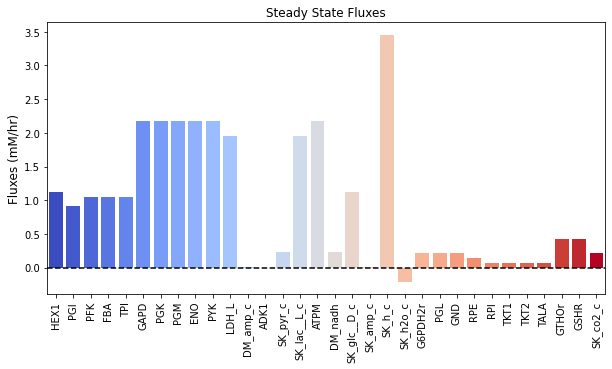

In [32]:
fig_11_9, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, list(ssfluxes.values()), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)]);
# Set labels and adjust ticks
ax.set_xticks(indicies);
ax.set_xticklabels(reaction_ids, rotation="vertical");
ax.set_ylabel("Fluxes (mM/hr)", L_FONT);
ax.set_title("Steady State Fluxes", L_FONT);
ax.plot([0, len(reaction_ids)], [0, 0], "k--");

**Figure 11.9:** Bar chart of the steady-state fluxes.

Note that this procedure leads to the decomposition of the steady state into four interlinked pathway vectors. All homeostatic states are simultaneously carrying out many functions. This multiplexing can be broken down into underlying pathways and thus leads to a clear interpretation of the steady state solution. 

**A numerical QC/QA:** Ensure $\textbf{Sv}_{\mathrm{stst}} = 0$

In [33]:
pd.DataFrame(
    fullppp.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"],
    dtype=np.int64).T

glc__D_c  g6p_c  f6p_c  fdp_c  dhap_c  g3p_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0         0      0      0      0       0       

                               _13dpg_c  _3pg_c  _2pg_c  pep_c  pyr_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0         0       0       0      0       

                               lac__L_c  nad_c  nadh_c  amp_c  adp_c  atp_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0         0      0       0      0      0       

                               pi_c  h_c  h2o_c  _6pgl_c  _6pgc_c  ru5p__D_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0     0    0      0        0        0           

                               xu5p__D_c  r5p_c  s7p_c  e4p_c  nadp_c  \
$\textbf{Sv}_{\mathrm{stst}}$  0          0      0      0      0        

                               nadph_c  gthrd_c  gthox_c  co2_c  
$\textbf{Sv}_{\mathrm{stst}}$  0        0        0        0

### Computing the rate constants  
The kinetic constants can be computed from the steady state values of the concentrations using elementary mass action kinetics. The computation is based on Eq. (10.4) The results from this computation is summarized in Table 11.13. Note that most of the PERCs are large, leading to rapid responses, except for the glutathiones. $v_{GSHR}$ clearly sets the slowest time scale. This table has all the reaction properties that we need to complete the MASS model.

In [34]:
percs = fullppp.calculate_PERCs(update_reactions=True)

**Table 11.13:** Combined glycolysis and pentose pathway enzymes and transport rates.

In [35]:
# Get concentration values for substitution into sympy expressions
value_dict = {sym.Symbol(str(met)): ic 
              for met, ic in fullppp.initial_conditions.items()}
value_dict.update({sym.Symbol(str(met)): bc 
                   for met, bc in fullppp.boundary_conditions.items()})

table_11_13 = []
# Get symbols and values for table and substitution
for p_key in ["Keq", "kf"]:
    symbol_list, value_list = [], []
    for p_str, value in fullppp.parameters[p_key].items():
        symbol_list.append(r"$%s_{\text{%s}}$" % (p_key[0], p_str.split("_", 1)[-1]))
        value_list.append("{0:.3f}".format(value) if value != INF else r"$\infty$")
        value_dict.update({sym.Symbol(p_str): value})
    table_11_13.extend([symbol_list, value_list])

table_11_13.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(fullppp.get_mass_action_ratios()).values()])
table_11_13.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(fullppp.get_disequilibrium_ratios()).values()])
table_11_13 = pd.DataFrame(np.array(table_11_13).T, index=reaction_ids,
                           columns=[r"$K_{eq}$ Symbol", r"$K_{eq}$ Value", "PERC Symbol", 
                                    "PERC Value", r"$\Gamma$", r"$\Gamma/K_{eq}$"])
table_11_13

$K_{eq}$ Symbol $K_{eq}$ Value  \
HEX1         $K_{\text{HEX1}}$         850.000         
PGI          $K_{\text{PGI}}$          0.410           
PFK          $K_{\text{PFK}}$          310.000         
FBA          $K_{\text{FBA}}$          0.082           
TPI          $K_{\text{TPI}}$          0.057           
GAPD         $K_{\text{GAPD}}$         0.018           
PGK          $K_{\text{PGK}}$          1800.000        
PGM          $K_{\text{PGM}}$          0.147           
ENO          $K_{\text{ENO}}$          1.695           
PYK          $K_{\text{PYK}}$          363000.000      
LDH_L        $K_{\text{LDH_L}}$        26300.000       
DM_amp_c     $K_{\text{DM_amp_c}}$     $\infty$        
ADK1         $K_{\text{ADK1}}$         1.650           
SK_pyr_c     $K_{\text{SK_pyr_c}}$     1.000           
SK_lac__L_c  $K_{\text{SK_lac__L_c}}$  1.000           
ATPM         $K_{\text{ATPM}}$         $\infty$        
DM_nadh      $K_{\text{DM_nadh}}$      $\infty$        
SK_glc__D_c  $K_{\text{SK_glc__D_c}}$  $\infty$        
SK_amp_c     $K_{\text{SK_amp_c}}$     $\infty$        
SK_h_c       $K_{\text{SK_h_c}}$       1.000           
SK_h2o_c     $K_{\text{SK_h2o_c}}$     1.000           
G6PDH2r      $K_{\text{G6PDH2r}}$      1000.000        
PGL          $K_{\text{PGL}}$          1000.000        
GND          $K_{\text{GND}}$          1000.000        
RPE          $K_{\text{RPE}}$          3.000           
RPI          $K_{\text{RPI}}$          2.570           
TKT1         $K_{\text{TKT1}}$         1.200           
TKT2         $K_{\text{TKT2}}$         10.300          
TALA         $K_{\text{TALA}}$         1.050           
GTHOr        $K_{\text{GTHOr}}$        100.000         
GSHR         $K_{\text{GSHR}}$         2.000           
SK_co2_c     $K_{\text{SK_co2_c}}$     1.000           

                          PERC Symbol   PERC Value     $\Gamma$  \
HEX1         $k_{\text{HEX1}}$         0.700        0.008809      
PGI          $k_{\text{PGI}}$          2961.111     0.407407      
PFK          $k_{\text{PFK}}$          33.158       0.133649      
FBA          $k_{\text{FBA}}$          2657.407     0.079781      
TPI          $k_{\text{TPI}}$          32.208       0.045500      
GAPD         $k_{\text{GAPD}}$         3271.226     0.006823      
PGK          $k_{\text{PGK}}$          1233733.418  1755.073081   
PGM          $k_{\text{PGM}}$          4716.446     0.146184      
ENO          $k_{\text{ENO}}$          1708.624     1.504425      
PYK          $k_{\text{PYK}}$          440.186      19.570304     
LDH_L        $k_{\text{LDH_L}}$        1073.943     44.132974     
DM_amp_c     $k_{\text{DM_amp_c}}$     0.161        11.530288     
ADK1         $k_{\text{ADK1}}$         100000.000   1.650000      
SK_pyr_c     $k_{\text{SK_pyr_c}}$     744.186      0.995008      
SK_lac__L_c  $k_{\text{SK_lac__L_c}}$  5.406        0.735294      
ATPM         $k_{\text{ATPM}}$         1.356        0.453125      
DM_nadh      $k_{\text{DM_nadh}}$      7.442        1.956811      
SK_glc__D_c  $k_{\text{SK_glc__D_c}}$  1.120        1.000000      
SK_amp_c     $k_{\text{SK_amp_c}}$     0.014        0.086728      
SK_h_c       $k_{\text{SK_h_c}}$       128645.833   0.701253      
SK_h2o_c     $k_{\text{SK_h2o_c}}$     100000.000   1.000000      
G6PDH2r      $k_{\text{G6PDH2r}}$      21864.589    11.875411     
PGL          $k_{\text{PGL}}$          122.323      21.362698     
GND          $k_{\text{GND}}$          29287.807    43.340651     
RPE          $k_{\text{RPE}}$          16048.911    2.994699      
RPI          $k_{\text{RPI}}$          9645.957     2.566222      
TKT1         $k_{\text{TKT1}}$         1675.750     0.932371      
TKT2         $k_{\text{TKT2}}$         1146.859     1.921130      
TALA         $k_{\text{TALA}}$         886.847      0.575416      
GTHOr        $k_{\text{GTHOr}}$        53.330       0.259372      
GSHR         $k_{\text{GSHR}}$         0.041        0.011719      
SK_co2_c     $k_{\text{SK_co2

## Simulating an Increase in ATP Utilization
### Validating the steady state 
We can see from Figure 11.7 that the model is not in a steaty state. Therefore, as a QC/QA test, we simulate the model to ensure that the system is in a steady state after our PERC and steady state flux calculations.

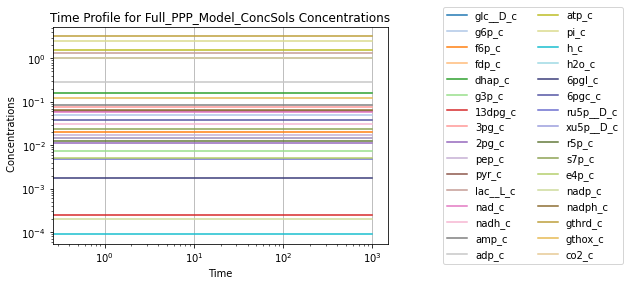

In [36]:
t0, tf = (0, 1e3)
sim_fullppp = Simulation(fullppp)
sim_fullppp.find_steady_state(fullppp, strategy="simulate",
                              update_values=True)
conc_sol_ss, flux_sol_ss = sim_fullppp.simulate(
    fullppp, time=(t0, tf, tf*10 + 1))
# Quickly render and display time profiles 
conc_sol_ss.view_time_profile()

**Figure 11.10:** The merged model after determining the steady state conditions.

We can compare the differences in the initial state of each model before merging and after. 

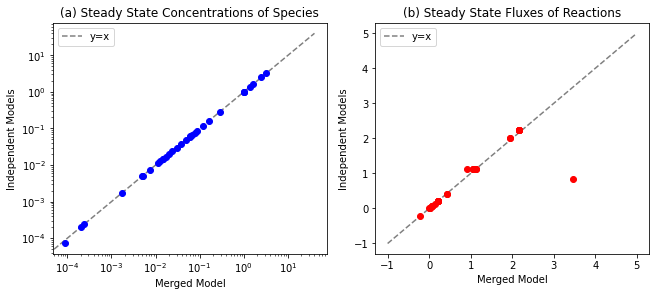

In [37]:
fig_11_11, axes = plt.subplots(1, 2, figsize=(9, 4), 
                               constrained_layout=True)
(ax1, ax2) = axes.flatten()

# Compare initial conditions
initial_conditions = {
    m.id: ic for m, ic in glycolysis.initial_conditions.items()
    if m.id in fullppp.metabolites}
initial_conditions.update({
    m.id: ic for m, ic in ppp.initial_conditions.items()
    if m.id in fullppp.metabolites})

plot_comparison(
    fullppp, pd.Series(initial_conditions), compare="concentrations",
    ax=ax1, plot_function="loglog",
    xlabel="Merged Model", ylabel="Independent Models",
    title=("(a) Steady State Concentrations of Species", L_FONT),
    color="blue", xy_line=True, xy_legend="best");

# Compare fluxes
fluxes = {
    r.id: flux for r, flux in glycolysis.steady_state_fluxes.items()
    if r.id in fullppp.reactions}
fluxes.update({
    r.id: flux for r, flux in ppp.steady_state_fluxes.items()
    if r.id in fullppp.reactions})

plot_comparison(
    fullppp, pd.Series(fluxes), compare="fluxes", 
    ax=ax2, plot_function="plot",
    xlabel="Merged Model", ylabel="Independent Models",
    title=("(b) Steady State Fluxes of Reactions", L_FONT),
    color="red", xy_line=True, xy_legend="best");

**Figure 11.11:** Comparisons between the initial conditions of the merged model and the initial conditions of the independent glycolysis and pentose phosphate pathway networks for (a) the species and (b) the fluxes.

### Response to an increased $k_{ATPM}$

First, we must ensure that the system is originally at steady state. We perform the same simulation as in the last chapter by increasing the rate of ATP utilization. 

In [38]:
conc_sol, flux_sol = sim_fullppp.simulate(
    fullppp, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"})

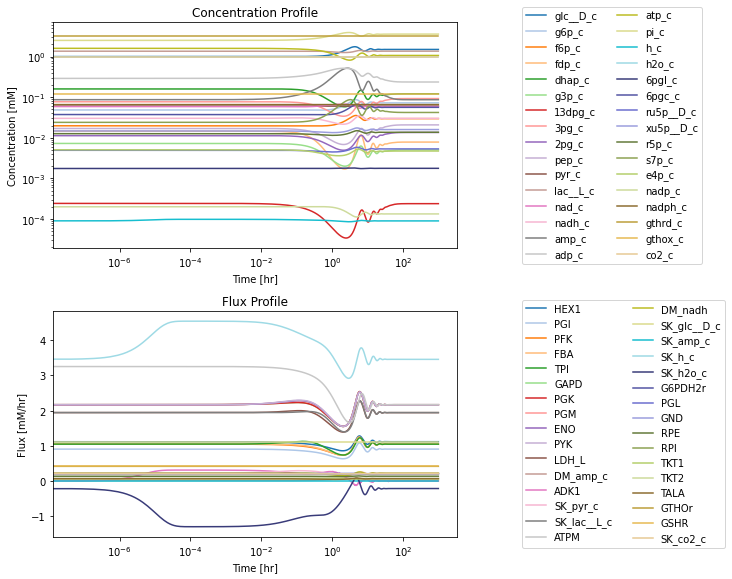

In [39]:
fig_11_12, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), 
                               constrained_layout=True);
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside", 
    plot_function="loglog", 
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));

**Figure 11.12:** Simulating the combined system from the steady state with 50% increase in the rate of ATP utilization at t = 0.

The dynamic phase portraits are shown in Figure 11.13 for the same key fluxes as for glycolysis alone (Figure 10.15). The response is similar, except the dampened oscillations are more pronounced. The oxidative branch of the pentose pathway is not affected, as the GSH load is not changed (Figure 11.13e), while the damped oscillations do occur in the non-oxidative branch (Figure 11.13f). The dashed lines show the glycolytic phase portraits (before the pentose phosphate pathway was added).

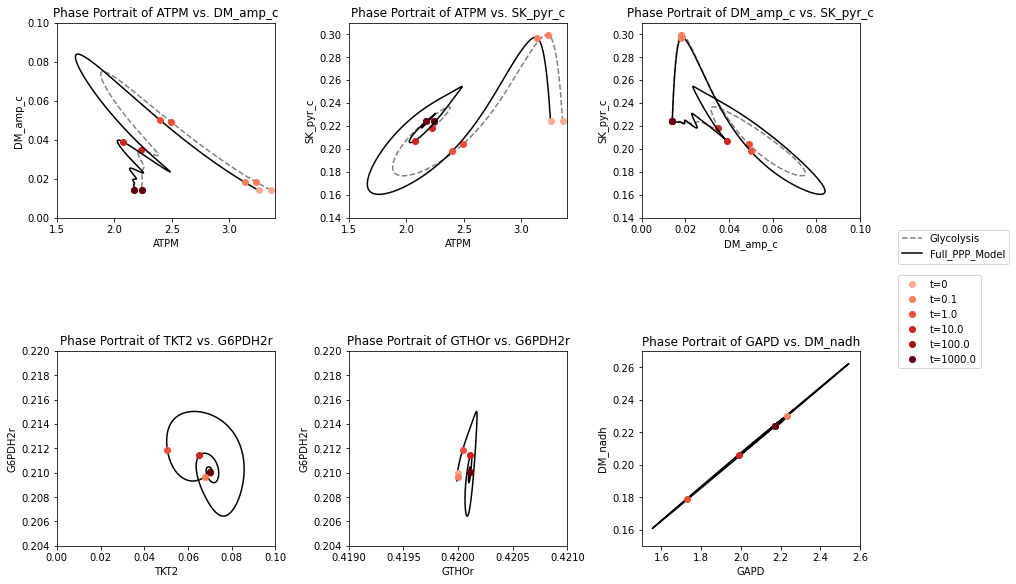

In [40]:
fig_11_13, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8),
                               constrained_layout=True)

time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]
    
pairings = [
    ("ATPM", "DM_amp_c"), ("ATPM", "SK_pyr_c"), ("DM_amp_c", "SK_pyr_c"), 
    ("TKT2", "G6PDH2r"), ("GTHOr", "G6PDH2r"), ("GAPD", "DM_nadh")]
xlims = [
    (1.50, 3.40), (1.50, 3.40), (0.00, 0.10),
    (0.000, 0.100), (0.419, 0.421), (1.50, 2.60)]
ylims = [
    (0.00, 0.10), (0.14, 0.31), (0.14, 0.31),
    (0.204, 0.220), (0.204, 0.220), (0.15, 0.27)]

colors = ["grey", "black"]
styles = ["--", "-"]
for k, model in enumerate([glycolysis, fullppp]):
    sim = Simulation(model)
    flux_solution = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"})[1]

    for i, ax in enumerate(axes.flatten()):
        if i >= 3 and k == 0:
            continue
        legend, time_point_legend = None, None
        if i == 2:
            legend = [model.id, "lower right outside"]
        if i == 5:
            time_point_legend = "upper right outside"
        x_i, y_i = pairings[i]
        plot_phase_portrait(
            flux_solution, x=x_i, y=y_i, ax=ax, legend=legend,
            xlabel=x_i, ylabel=y_i, 
            xlim=xlims[i], ylim=ylims[i],
            title=("Phase Portrait of {0} vs. {1}".format(
                x_i, y_i), L_FONT),
            color=colors[k],
            linestyle=styles[k],
            annotate_time_points=time_points,
            annotate_time_points_color=time_point_colors,
            annotate_time_points_legend=time_point_legend)

**Figure 11.13:** Dynamic response of the integrated system of glycolysis and the pentose pathway to increasing the rate of ATP utilization. The dynamic response of key fluxes are shown. Detailed pair-wise phase portraits: a): $v_{ATPM}\ \textit{vs.}\ v_{DM_{AMP}}$. b): $v_{ATPM}\ \textit{vs.}\ v_{SK_{PYR}}$. c): $v_{DM_{AMP}}\ \textit{vs.}\ v_{SK_{PYR}}$. d): $v_{TKT2}\ \textit{vs.}\ v_{G6PDH2r}$. e): $v_{GTHOr}\ \textit{vs.}\ v_{G6PDH2r}$. f): $v_{GAPD}\ \textit{vs.}\ v_{DM_{NADH}}$. These phase portrait can be compared to the corresponding ones in Figure 10.15. The perturbation is reflected in the instantaneous move of the flux state from the initial steady state to an unsteady state, as indicated by the arrow placing the initial point at $t=0^+$. The system then returns to its steady state at $t \rightarrow \infty$. The dashed lines show the phase portraits of the original glycolysis model.

### Relative deviations from the initial state
As shown in the figure below, AMP still has the highest perturbation. However, we can see that sedulose 7-phosphate also has a fairly high deviation from its initial condition. Note that there is slightly more variation in the concentration profiles at around $t = 10$ than in glycolysis alone. We can see that the flux deviations also follow the same general trend as the glycolysis simulations, with slightly more variation.

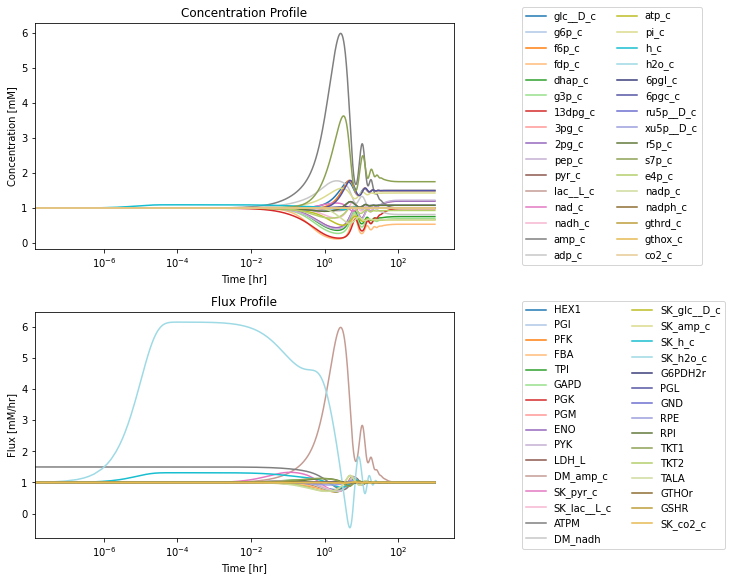

In [41]:
fig_11_14, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), 
                               constrained_layout=True);
(ax1, ax2) = axes.flatten()

conc_deviation = {met.id: conc_sol[met.id]/ic 
                  for met, ic in fullppp.initial_conditions.items()}
conc_deviation = MassSolution(
    "Deviation", solution_type="Conc",
    data_dict=conc_deviation,
    time=conc_sol.t, interpolate=False)

flux_deviation = {rxn.id: flux_sol[rxn.id]/ssflux 
                  for rxn, ssflux in fullppp.steady_state_fluxes.items()
                  if ssflux != 0 and rxn.id != "ADK1"} # To avoid dividing by 0 for equilibrium fluxes.

flux_deviation = MassSolution(
    "Deviation", solution_type="Flux",
    data_dict=flux_deviation, 
    time=flux_sol.t, interpolate=False)

plot_time_profile(
    conc_deviation, ax=ax1, legend="right outside", 
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_deviation, ax=ax2, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));

**Figure 11.14:** (a) Deviation from the steady state of the concentrations as a fraction of the steady state. (b) Deviation from the steady state of the fluxes as a fraction of the steady state.

**Table 11.13:** Numerical values for the concentrations (mM) and fluxes (mM/hr) at the beginning and end of the dynamic simulation. The concentration of water is arbitrarily set at 1.0. At $t=0$ the $v_{ATPM}$ flux changes from 2.24 to 3.36, unbalancing the flux map. The flux map returns to its original state as time goes to infinity (here $t=1000$). Note that unlike the fluxes, the concentrations reach a different steady state.

In [42]:
met_ids = metabolite_ids.copy()
init_concs = [round(ic[0], 3) for ic in conc_sol.values()]
final_concs = [round(bc[-1], 3) for bc in conc_sol.values()]
column_labels = ["Metabolite", "Conc. at t=0 [mM]", "Conc. at t=1000 [mM]"]

rxn_ids = reaction_ids.copy()
init_fluxes = [round(ic[0], 3) for ic in flux_sol.values()]
final_fluxes = [round(bc[-1], 3) for bc in flux_sol.values()]
column_labels += ["Reactions", "Flux at t=0 [mM/hr]", "Flux at t=1000 [mM/hr]"]

# Extend metabolite columns to match length of reaction columns for table
pad = [""]*(len(reaction_ids) - len(metabolite_ids))
# Make table
table_11_13 = np.array([metabolite_ids + pad, init_concs + pad, final_concs + pad, 
                        reaction_ids, init_fluxes, final_fluxes])
table_11_13 = pd.DataFrame(table_11_13.T, 
                           index=[i for i in range(1, len(reaction_ids) + 1)],
                           columns=column_labels)
def highlight_table(x):
    # ATPM is the 16th reaction according to Table 10.2
    return ['color: red' if x.name == 16 else '' for v in x]

table_11_13 = table_11_13.style.apply(highlight_table, subset=column_labels[3:], axis=1)
table_11_13

As before, we will examine the node balances to gain a better understanding of the system's response.

#### The proton node for $k_{ATPM}$ perturbation
The proton node now has 8 production reactions and 4 utilization reactions. The fluxes in and out of the node can be graphed, and so can the proton concentration (the inventory in the node).  

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


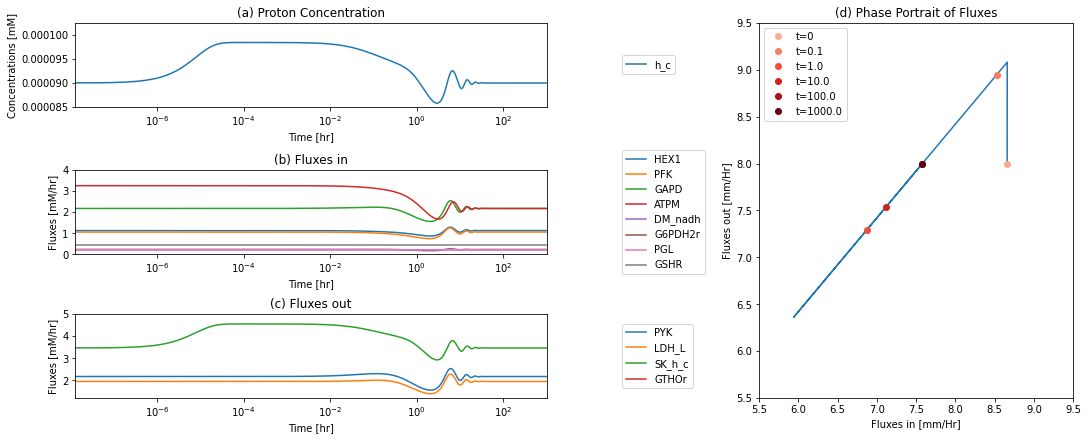

In [43]:
fig_11_15 = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = fig_11_15.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_11_15.add_subplot(gs[0, 0])
ax2 = fig_11_15.add_subplot(gs[1, 0])
ax3 = fig_11_15.add_subplot(gs[2, 0])
ax4 = fig_11_15.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(8.5e-5, 1e-4*1.025),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "PFK", "GAPD", "ATPM", "DM_nadh",
             "G6PDH2r", "PGL", "GSHR"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf),  ylim=(0, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PYK", "LDH_L","SK_h_c", "GTHOr"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf),  ylim=(1.2, 5), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(5.5, 9.5), ylim=(5.5, 9.5),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");

**Figure 11.15:**	The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in ATP utilization.

#### The NADPH node for $k_{ATPM}$ perturbation
Here, we examine the NADPH node. It has a connectivity of 3: two inputs and one output. 

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


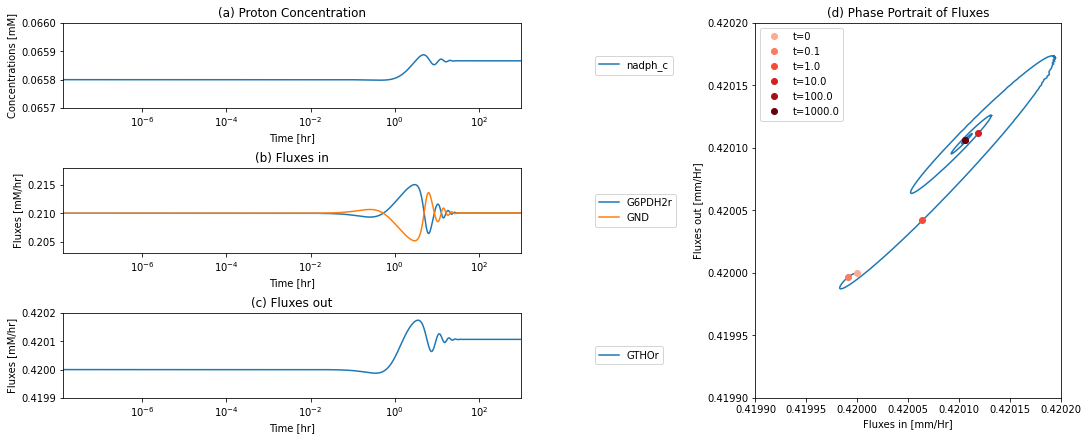

In [44]:
fig_11_15 = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = fig_11_15.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_11_15.add_subplot(gs[0, 0])
ax2 = fig_11_15.add_subplot(gs[1, 0])
ax3 = fig_11_15.add_subplot(gs[2, 0])
ax4 = fig_11_15.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="nadph_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.0657, 0.066),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["G6PDH2r", "GND"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf),  ylim=(0.203, 0.218),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["GTHOr"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.4199, 0.4202),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(0.4199, 0.4202), ylim=(0.4199, 0.4202),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");

**Figure 11.16:**	The time profiles of the (a) NADPH concentration, (b) the fluxes that make NADPH, (c) the fluxes that use NADPH and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in ATP utilization.

#### Key Fluxes and all pairwise phase portraits
Figure 11.17 and Figure 11.18 are set up to allow the reader to examine all pairwise phase portraits  After browsing through many of them, you will find that they resemble each other, showing that the variables move in a highly coordinated manner.  We can study the relationship between many variables at once using multi-variate statistics.  

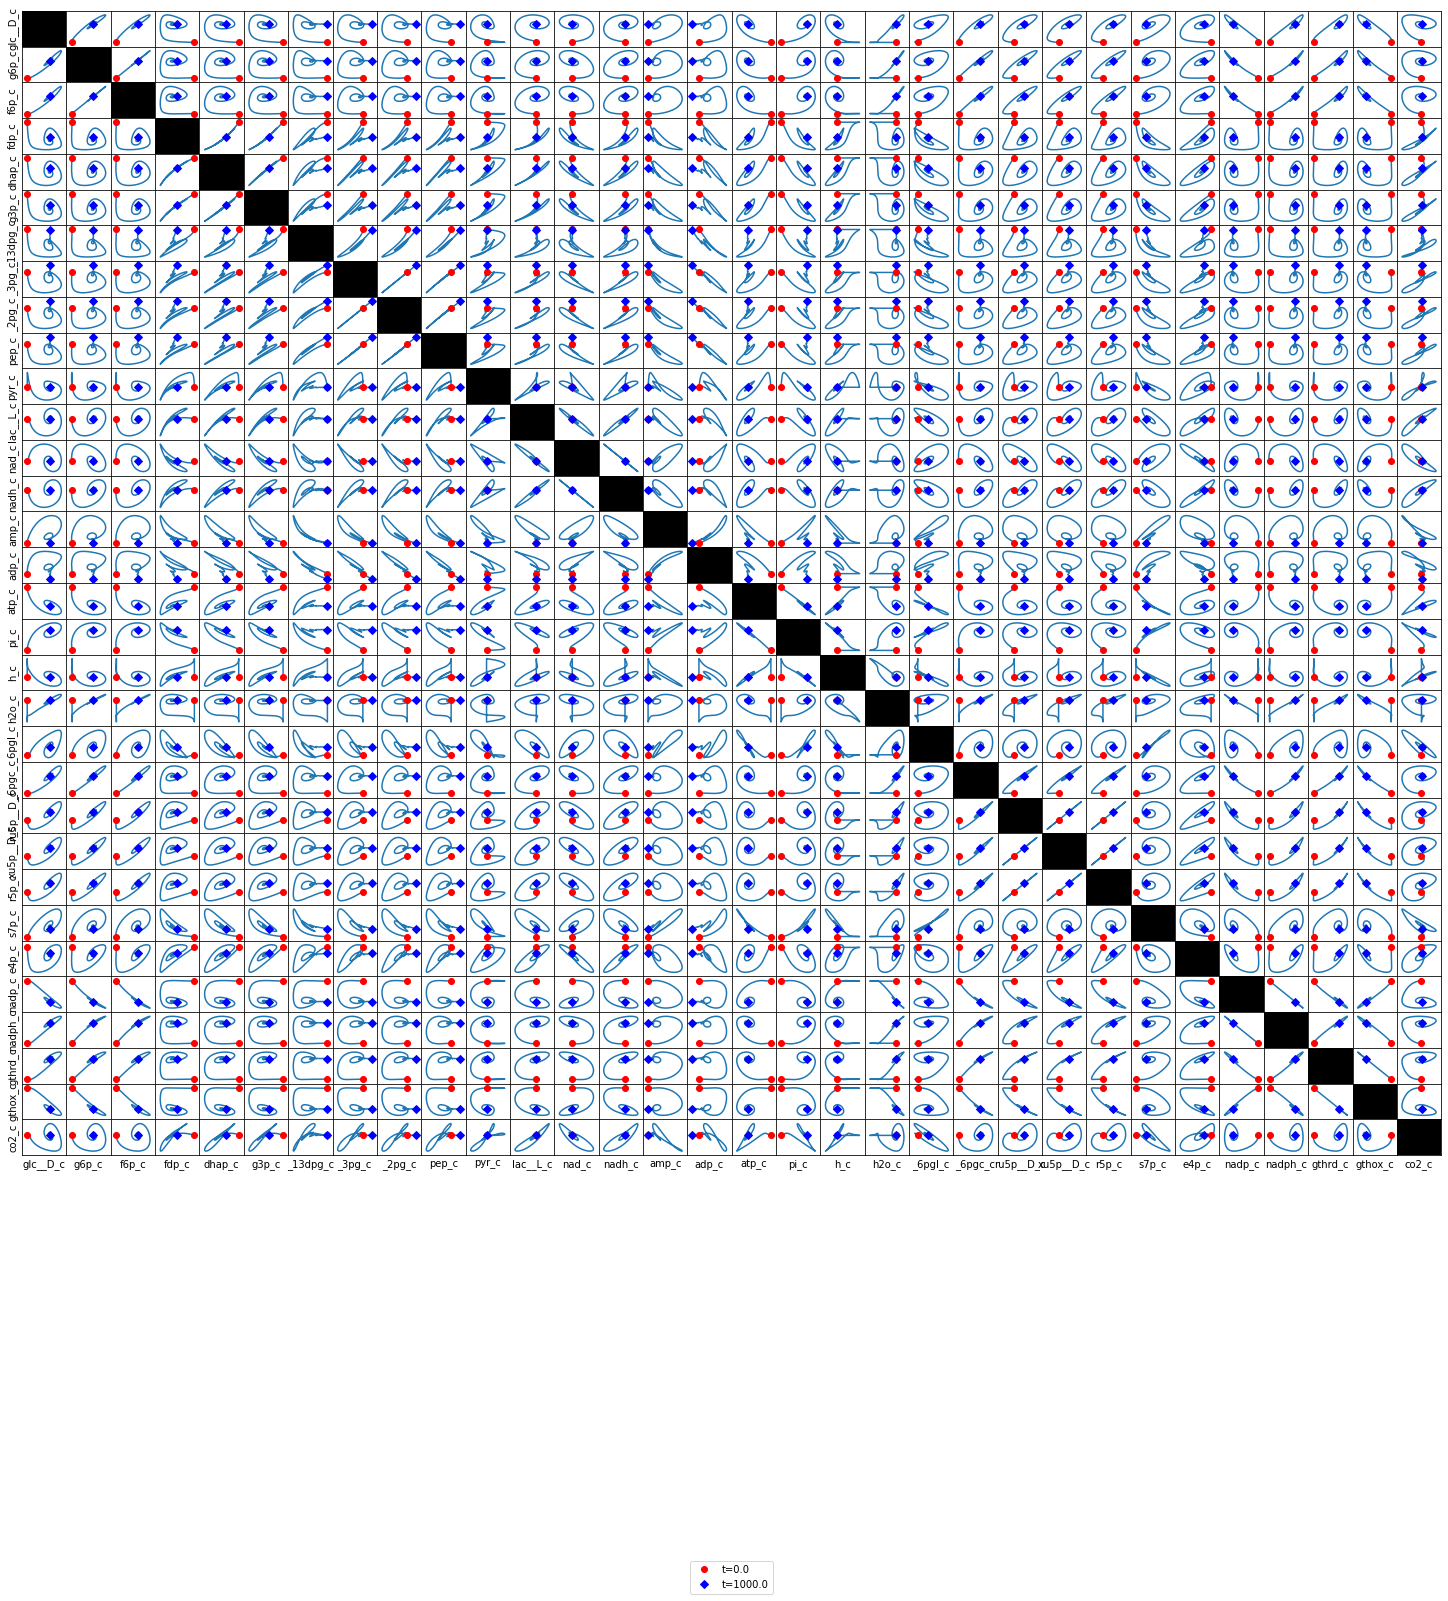

In [45]:
fig_11_17, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 22), 
                             constrained_layout=True)
plot_tiled_phase_portraits(
    conc_sol, ax=ax, annotate_time_points_legend="lower outside");

**Figure 11.17:** Phase portraits of all the combined glycolytic and pentose phosphate pathway species.

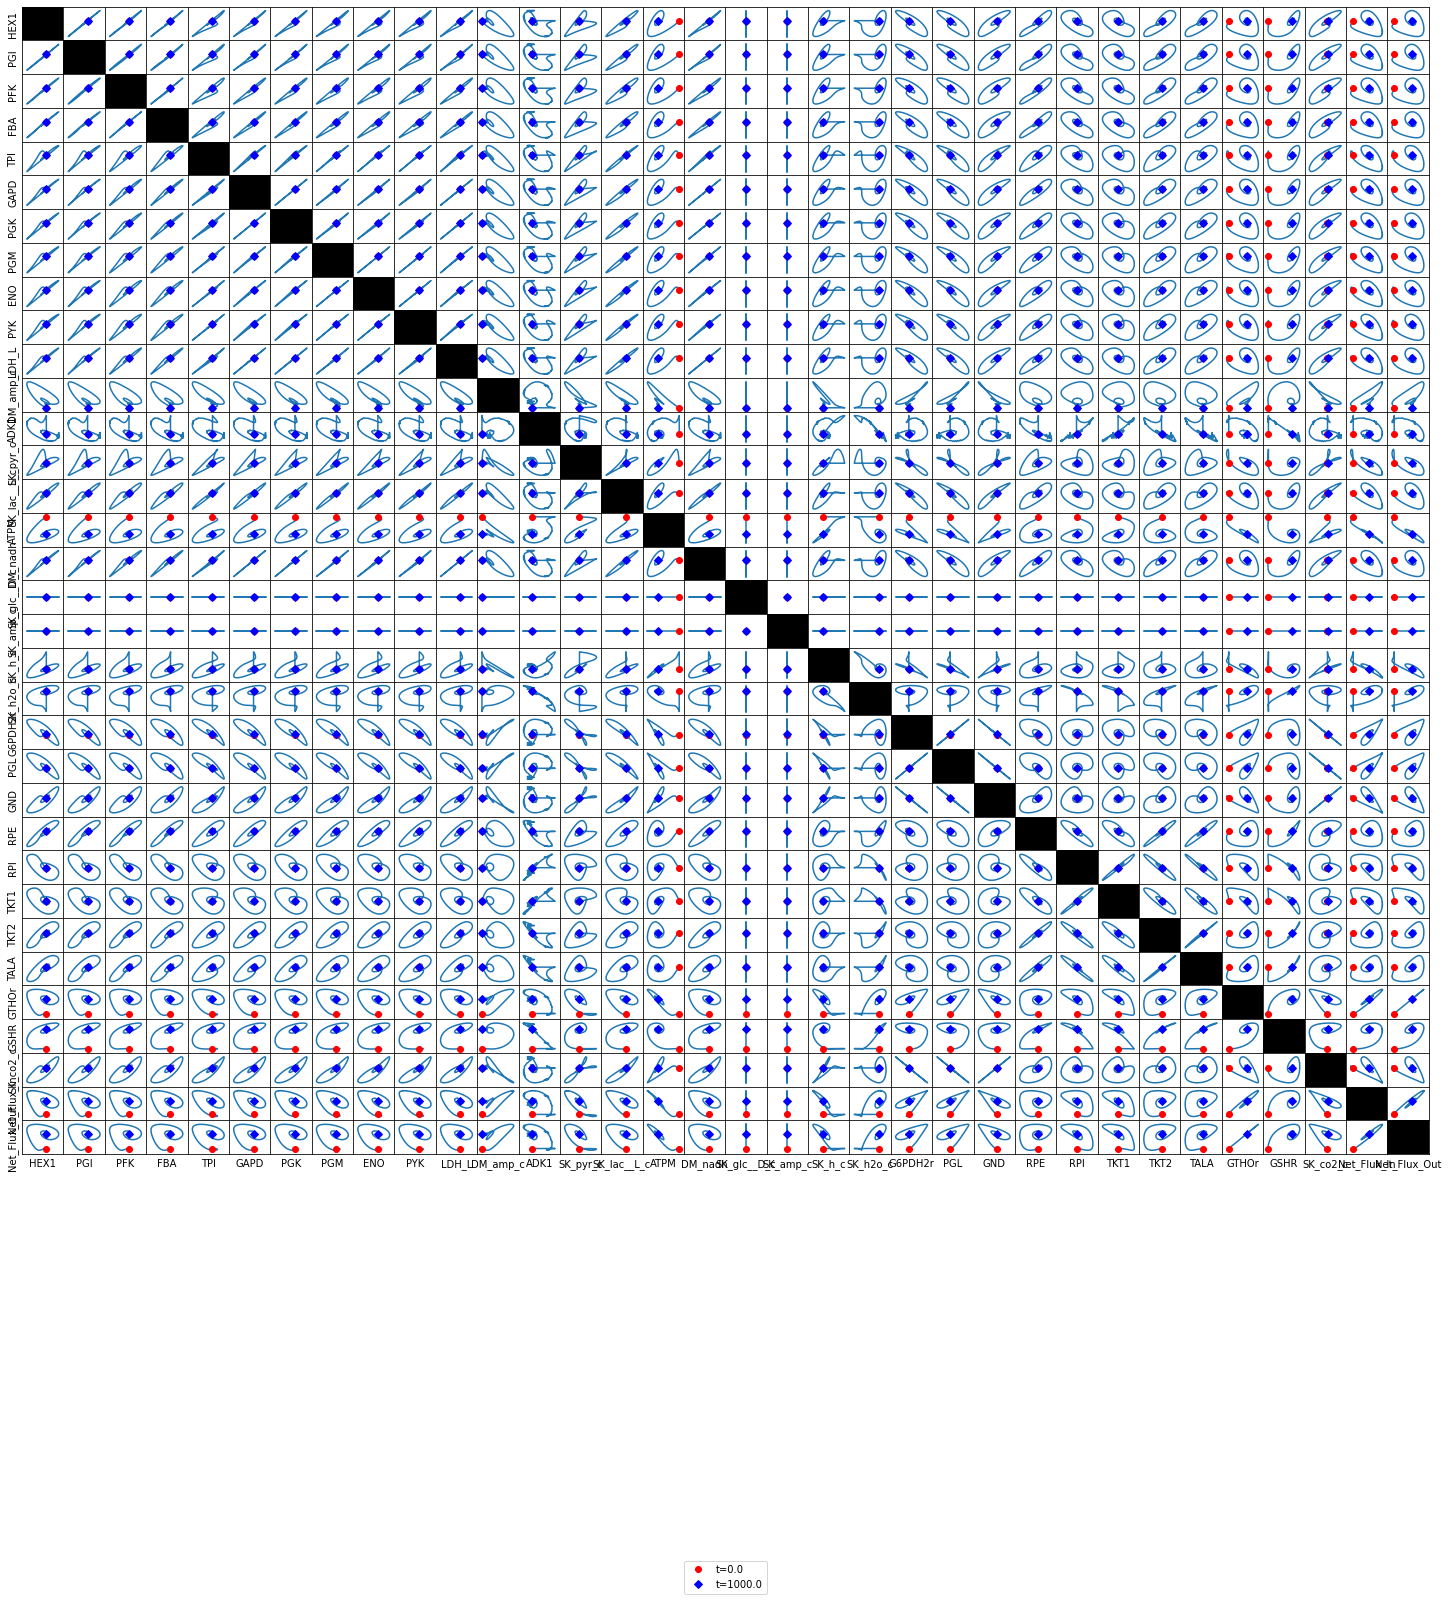

In [46]:
fig_11_18, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 22), 
                             constrained_layout=True)
plot_tiled_phase_portraits(
    flux_sol, ax=ax, annotate_time_points_legend="lower outside");

**Figure 11.18:** Phase portraits of all the combined glycolytic and pentose phosphate pathway fluxes.

### Response to an increased rate of GSH utilization  
The main function of the pentose pathway is to generate redox potential in the form of GSH. We are thus interested in the increased rate of GSH use. We simulate the doubling of the rate of GSH use (see Figure 11.19). The response is characteristic of a highly buffered system. The size of $G_{\mathrm{tot}}$ is 3.44 mM $(=3.2+2*0.12)$, which is a high concentration for this coupled pathway system. 

In [47]:
conc_sol, flux_sol = sim_fullppp.simulate(
    fullppp, time=(t0, tf, tf*10 + 1),
    perturbations={"kf_GSHR": "kf_GSHR * 2"})

The glutathione oxidase (the load) and the reductase reach a steady state within an hour at a higher flux level (Figure 11.19a), while the fluxes through the oxidative and non-oxidative branches of the pentose pathway increase, leading to increased $\text{CO}_2$ production. The loss of $\text{CO}_2$ leads to a lower flux through the upper and lower branches of glycolysis (Figure 11.19b). Thus the glycolytic intermediates drop slightly in concentration and the pentose pathway intermediates increase, as indicated by the levels of GAP and Ru5P (Figure 11.19c). 

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


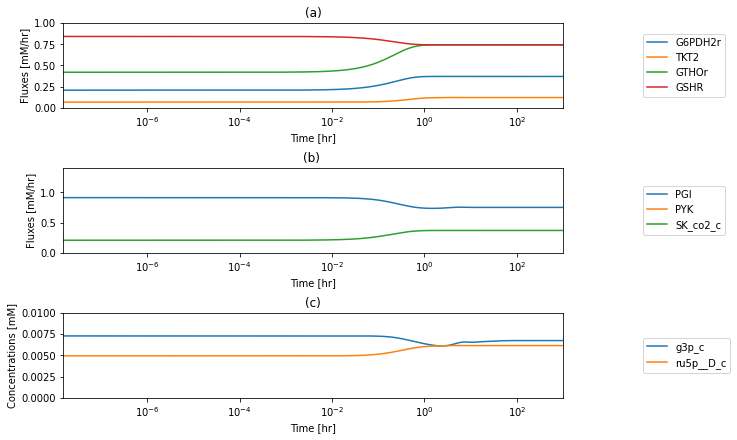

In [48]:
fig_11_19 = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = fig_11_19.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_11_19.add_subplot(gs[0, 0])
ax2 = fig_11_19.add_subplot(gs[1, 0])
ax3 = fig_11_19.add_subplot(gs[2, 0])

plot_time_profile(
    flux_sol, observable=["G6PDH2r", "TKT2", "GTHOr", "GSHR"],
    ax=ax1, legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0, 1),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(a)", L_FONT));

plot_time_profile(
    flux_sol, observable=["PGI", "PYK", "SK_co2_c"],
    ax=ax2, legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0, 1.4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) ", L_FONT));

plot_time_profile(
    conc_sol, observable=["g3p_c", "ru5p__D_c"], 
    ax=ax3, legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0, 0.01),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(c)", L_FONT));

**Figure 11.19:** Dynamic response of the integrated system of glycolysis and the pentose pathway, doubling the rate of GSH utilization. (a) The dynamic response of the fluxes in the oxidative $(v_{G6PDH2r})$ and the non-oxidative $(v_{TKT2})$ branches of the pentose pathway as well as GSH reductase and oxidase (the load). (b) The dynamic response of the upper $(v_{PGI})$ and lower $(v_{PYK})$ glycolytic fluxes, as well as $\text{CO}_2$ production by the pentose pathway. (c) The dynamic response of sample intermediates in glycolysis, GAP, and the pentose pathway, Ru5P*

As before, we will examine the node balances to gain a better understanding of the system's response.

#### The proton node for GSH utilization perturbation

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


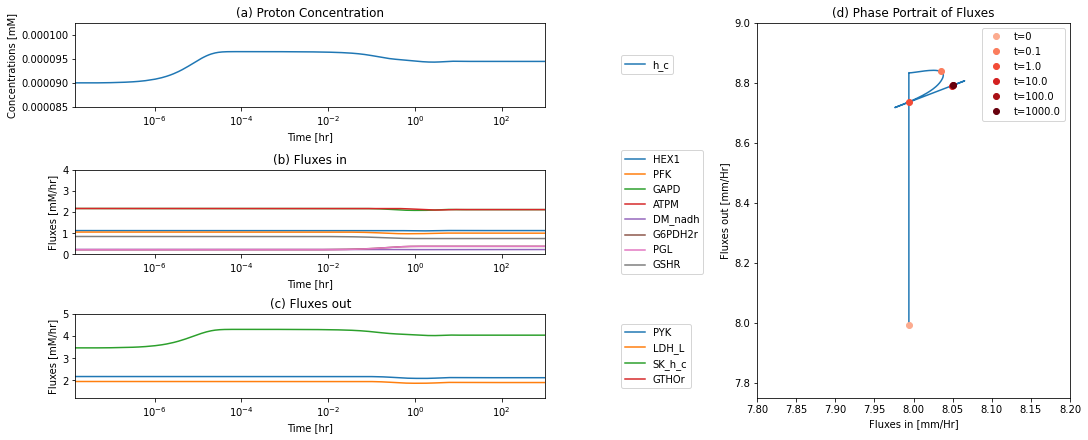

In [49]:
fig_11_20 = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = fig_11_20.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_11_20.add_subplot(gs[0, 0])
ax2 = fig_11_20.add_subplot(gs[1, 0])
ax3 = fig_11_20.add_subplot(gs[2, 0])
ax4 = fig_11_20.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(8.5e-5, 1e-4*1.025),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "PFK", "GAPD", "ATPM", "DM_nadh",
             "G6PDH2r", "PGL", "GSHR"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf),  ylim=(0, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PYK", "LDH_L","SK_h_c", "GTHOr"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf),  ylim=(1.2, 5), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(7.8, 8.2), ylim=(7.75, 9),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");

**Figure 11.20:**	The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in GSH utilization.

#### The NADPH node for GSH utilization perturbation

mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


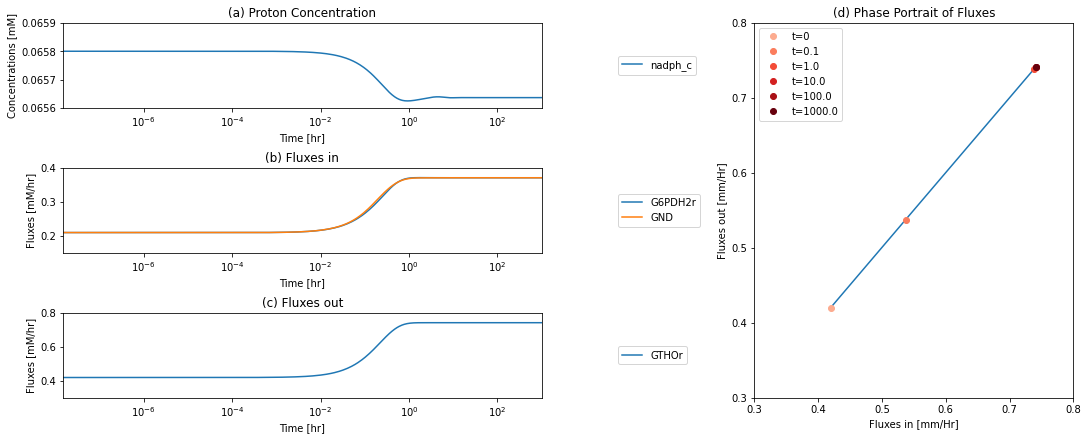

In [50]:
fig_11_21 = plt.figure(constrained_layout=True, figsize=(15, 6))
gs = fig_11_21.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_11_21.add_subplot(gs[0, 0])
ax2 = fig_11_21.add_subplot(gs[1, 0])
ax3 = fig_11_21.add_subplot(gs[2, 0])
ax4 = fig_11_21.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="nadph_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.0656, 0.0659),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["G6PDH2r", "GND"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.15, 0.4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["GTHOr"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(t0, tf), ylim=(0.3, 0.8),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(0.3, 0.8), ylim=(0.3, 0.8),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");

**Figure 11.21:**	The time profiles of the (a) NADPH concentration, (b) the fluxes that make NADPH, (c) the fluxes that use NADPH and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales) for an increase in GSH utilization.

## Pooling: Towards Systems Biology  
The combined glycolytic and pentose pathways have couplings to four cofactors: ATP, NADH and NADPH (and thus GSH), and $P_i$. The formation of the corresponding pools is clear as they show up in the left null space. The last four rows of Table 11.14 show these time-invariant, or 'hard' pools. We can form the time dependent pools based on analysis of the biochemical features of these coupled pathways. 

In [51]:
# Define the individual pools. The placement of each coefficient 
# corresponds to the order of the metabolites in the model as seen 
# in table_11_1.  _p indicates the positive superscript ^+ and 
# _n indicates the negative superscript (^-). 
def make_pooling_matrix(include_all=False):
    GP_p = np.array([2, 3, 3, 4, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 8/3, 8/3, 8/3, 10/3, 7/3, 0, 0, 0, 0, 0])
    GP_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    GR_p = np.array([2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 5/3, 5/3, 5/3, 7/3, 4/3, 0, 0, 0, 0, 0])
    GR_n = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0])
    GPR_p = np.array([6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 4, 4, 4, 8, 2, 0, 0, 0, 0, 0])
    GPR_n = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    P_p = np.array([0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    P_n = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0])
    AP_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    AP_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    N_p =  np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    N_n =  np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    NP_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    NP_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    G_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    G_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0])
    P_tot = P_p + P_n
    N_tot = N_p + N_n
    G_tot = G_p + G_n
    NP_tot = NP_p + NP_n

    # Define pooling matrix and pool labels
    if include_all:
        pool_labels = ["$GP^+$", "$GP^-$", "$GR^+$", "$GR^-$", "$GRP^+$", "$GRP^-$", 
                       "$P^+$", "$P^-$","$AP^+$", "$AP^-$", "$N^+$", "$N^-$", "$NP^+$", "$NP^-$", 
                       "$G^+$", "$G^-$","$P_{\mathrm{tot}}$", "$N_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$", 
                       "$NP_{\mathrm{tot}}$"]
        pooling_matrix = np.vstack([GP_p, GP_n, GR_p, GR_n, GPR_p, GPR_n,  P_p, P_n, AP_p, AP_n,
                                    N_p, N_n, NP_p, NP_n, G_p, G_n, P_tot, N_tot, G_tot, NP_tot])
    else:
        pool_labels = ["$GP^+$", "$GP^-$", "$GR^+$", "$GR^-$", "$GRP^+$", "$GRP^-$", 
                       "$P^+$", "$P^-$","$AP^+$", "$AP^-$", "$N^+$", "$NP^+$", "$G^+$",
                       "$P_{\mathrm{tot}}$", "$N_{\mathrm{tot}}$", "$G_{\mathrm{tot}}$", "$NP_{\mathrm{tot}}$"]
        pooling_matrix = np.vstack([GP_p, GP_n, GR_p, GR_n, GPR_p, GPR_n,  P_p, P_n, AP_p, AP_n,
                                    N_p,  NP_p, G_p, P_tot, N_tot, G_tot, NP_tot])
    # Round to 3 decimals
    pooling_matrix = np.array([[round(col, 3) for col in row] for row in pooling_matrix])
    return pooling_matrix, pool_labels
include_all = False

**Table 11.14:** Definition of functional pools for merged glycolysis and the pentose pathway. The left null space vectors for the stoichiometric matrix for coupled glycolytic and the pentose pathways in Table 11.11 are the last four rows in the table. The four time-invariant pools represent: 1) total phosphate, 2) total NADH, 3) total glutathione, and 4) total NADPH.

In [52]:
# Make table content from the pooling matrix, connectivity and
# participation numbers, and pool labels
pooling_matrix, pool_labels = make_pooling_matrix(include_all)
pool_numbers = np.array([[i for i in range(1, len(pool_labels) + 1)] + [""]])
pi = np.count_nonzero(pooling_matrix, axis=0)
rho = np.array([np.concatenate((np.count_nonzero(pooling_matrix, axis=1), [""]))])
table_11_14 = np.vstack((pooling_matrix, pi))
table_11_14 = np.hstack((pool_numbers.T, table_11_14, rho.T))

index_labels = pool_labels + [pi_str]
column_labels = ["Pool #"] + metabolite_ids + [rho_str]
table_11_14 = pd.DataFrame(table_11_14, index=index_labels, 
                           columns=column_labels)

# Highlight table
n_colors = int(np.ceil(len(pool_labels)/2))
color_list = [mpl.colors.to_hex(c) for c in mpl.cm.Set3(np.linspace(0, 1, n_colors))]
colors = dict(zip(["GP", "GR", "GRP", "P", "AP", "N", "NP", "G", "tot"], color_list))
colors.update({pi_str: "#99ffff",    # Cyan
               rho_str: "#ff9999",   # Red
               "blank": "#f2f2f2"}) # Grey
bg_color_str = "background-color: "
def highlight_table(df):
    df = df.copy()
    for row in df.index:
        if row == pi_str:
            main_key = pi_str
        elif row[1:-3] in colors:
            main_key = row[1:-3]
        else:
            main_key = "tot"
        df.loc[row, :] = [bg_color_str + colors[main_key] if v != "" 
                          else bg_color_str + colors["blank"] 
                          for v in df.loc[row, :]]
    for col in df.columns:
        if col == rho_str:
            df.loc[:, col] = [bg_color_str + colors[rho_str] 
                              if v != bg_color_str + colors["blank"]
                              else v for v in df.loc[:, col]]
    return df

table_11_14 = table_11_14.style.apply(highlight_table, axis=None)
table_11_14

### Using shadow prices to determine the cofactor value of intermediates  

The value of the intermediates needed to generate a charged form of a cofactor is hard to obtain by mere inspection of the coupled pathways. As the scope of models grows, this cofactor value determination becomes increasingly difficult. 

The cofactor values of the intermediates can be obtained using established methods of systems biology. These values can be generated from the shadow prices generated by linear optimization (see _Systems Biology: Properties of Reconstructed Networks, Chapter 15_). Here, the stoichiometric matrix and the inputs and outputs are used to formulate a linear optimization problem: 

$$\begin{equation}
\text{max (cofactor production) subject to}\ \textbf{Sv}=0;\ \text{and the input of glucose} =1
\tag{11.5}
\end{equation}$$

The maximum amount of a charged version of the cofactor produced (e.g., ATP) is computed from a single glucose molecule entering the system. The shadow prices for the intermediates give the sensitivity of the objective function (i.e., ATP production) with respect to the infinitesimal addition of that intermediate. The shadow prices can thus give the value of the intermediates for the production of a particular cofactor. 

An alternative way to evaluate the cofactor generation value of the intermediates is: 

$$\begin{equation} \text{max (cofactor production) subject to}\ \textbf{Sv}=0;\\
\text{and the input of the intermediate of interest} =1
\end{equation}$$
$$\tag{11.6}$$

and by adding an exchange rate for the intermediate of interest. This alternative approach would need many optimization computations, whereas all the shadow prices can be obtained from a single optimization computation. 

### Defining a pooling matrix  
The results from shadow price computations are used in forming the pooling matrix (Table 11.15). The values of the glycolytic intermediates are the same as before, but we can now add the ATP and NADH value of the pentose pathway intermediates. In addition, we can compute the value of the intermediates with respect to generating redox potential in the form of NADPH (or GSH). The high energy bond value of the intermediates in the combined pathways are shown in the first two lines $(GP^+, GP^-)$. The next two lines do the same for the NADH value $(GR^+, GR^-)$, and then the following two lines give new pools for the NADPH value of the intermediates $(GPR^+, GPR^-)$. The following four pools give the state of the phosphates $(P^+, P^-)$ as well as the energy value of the adenosine phosphates $(AP^+, AP^-)$. These are the same as for glycolysis alone. The next three lines give the redox carriers $(N^+, NP^+, G^+)$. The bottom four pools are the time invariant pools that are in the left null space of $\textbf{S}$. 

### The reactions that move the pools  
The fluxes that move the pools can be determined by computing $\textbf{PS}$. The results are shown in Table 11.15. These pools can be added to the pool-flux map of glycolysis (Figure 10.20). 

**Table 11.15:** The fluxes that flow in and out of the pools defined in Table 11.14.

In [53]:
# Make table content from the pooling matrix, connectivity and
# participation numbers, pool sizes, and time constants
pooling_matrix, pool_labels = make_pooling_matrix(include_all)
PS = pooling_matrix.dot(fullppp.S)
PS = np.array([[round(col, 3) for col in row] for row in PS])

pi = np.count_nonzero(PS, axis=0)
rho = np.count_nonzero(PS, axis=1)
ic_values = [fullppp.initial_conditions[met] 
             for met in fullppp.metabolites.get_by_any(metabolite_ids)]
pool_sizes = [round(np.sum([coeff*ic for coeff, ic in zip(row, ic_values)]), 5)
              for row in pooling_matrix]
flux_values = [fullppp.steady_state_fluxes[rxn] 
               for rxn in fullppp.reactions.get_by_any(reaction_ids)]
fluxes_in = [round(np.sum([coeff*flux for coeff, flux in zip(row, flux_values) 
                           if coeff >=0]), 5) for row in PS]
taus = [round(size/flux_in, 5) if flux_in != 0 
        else r"$\infty$" for size, flux_in in zip(pool_sizes, fluxes_in)]
table_11_15 = np.hstack((pool_numbers.T, 
                         np.vstack((PS, pi)), 
                         np.array([np.append(col, "") 
                                   for col in np.array([rho, pool_sizes, fluxes_in, taus])]).T))
index_labels = pool_labels + [pi_str]
column_labels = np.concatenate((["Pool #"], reaction_ids, 
                                [rho_str, "Size (mM)", "Net steady state flux (mM/hr)", r"$\tau$(h)"]))
table_11_15 = pd.DataFrame(table_11_15, index=index_labels,
                           columns=column_labels)
# Highlight table
colors.update({"Size (mM)": "#e6faff",                     # L. Blue
               "Net steady state flux (mM/hr)": "#f9ecf2", # L. Pink
               r"$\tau$(h)": "#e6ffe6"})                   # L. Green
bg_color_str = "background-color: "
def highlight_table(df):
    df = df.copy()
    for row in df.index:
        if row == pi_str:
            main_key = pi_str
        elif row[1:-3] in colors:
            main_key = row[1:-3]
        else:
            main_key = "tot"
        df.loc[row, :] = [bg_color_str + colors[main_key] if v != "" 
                          else bg_color_str + colors["blank"] 
                          for v in df.loc[row, :]]
    for col in df.columns:
        if col in colors:
            df.loc[:, col] = [bg_color_str + colors[col] 
                              if v != bg_color_str + colors["blank"]
                              else v for v in df.loc[:, col]]
    return df

table_11_15 = table_11_15.style.apply(highlight_table, axis=None)
table_11_15

## Ratios: Towards Physiology  
The five ratios from the glycolytic system alone carry over to the system of the combined pathways. The addition of the pentose pathway adds new property ratios related to the type of redox charge that NADPH carries. 

### Additional redox charges  
The quotient between the charged and uncharged states can be used to define property ratios as in Chapter 10. The ratios are the same here as for glycolysis, with the addition of the following redox charges: 

* the NADPH conversion value of the intermediates; 


$$\begin{equation} r_6 = \frac{GRP^+}{GRP^+ + GRP^-} \tag{11.6} \end{equation}$$

* the NADPH carrier; 


$$\begin{equation}r_7 = \frac{\text{NADPH}}{\text{NADPH} + \text{NADP}} = \frac{NP^+}{NP^+ + NP^-} \tag{11.7} \end{equation}$$

* the glutathione carrier 


$$\begin{equation} r_8 = \frac{\text{GSH}}{\text{GSH} + 2\text{GSSG}} \tag{11.8} \end{equation}$$

### Dynamic responses of the ratios  

The response to the increased rate of GSH utilization on the cofactor charge ratios is shown in Figure 11.7.1. The glutathione redox charge drops from 0.93 to 0.88 (Figure 11.22a) and complementary to that there is a modest increase in the NADPH redox charge (Figure 11.22b). Figure 11.22c and Figure 11.22d show the dip in the NADH redox charge and the adenosine phosphate energy charge that result from the effect that increased pentose pathway flux has on reduced glycolysis flux. These ratios drop modestly but then return almost to their exact initial value. Thus, there is dynamic interaction between the pathways, but the steady state remains similar. 

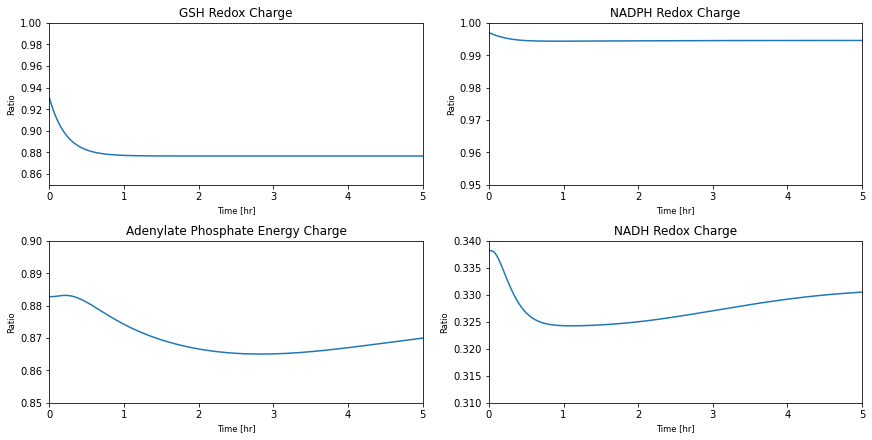

In [54]:
# Make pool solutions
pooling_matrix, pool_labels = make_pooling_matrix(True)
pools = {}
for i, pool_id in enumerate(pool_labels[:-2]):
    terms = ["*".join((str(coeff), met))
             for coeff, met in zip(pooling_matrix[i], metabolite_ids)
             if coeff != 0]
    variables = [term.split("*")[-1] for term in terms]
    pools.update({pool_id: ["+".join(terms), variables]})

ratios = {}
keys = [('$G^+$', '$G^-$'), ('$NP^+$', '$NP^-$'), 
        ('$AP^+$', '$AP^-$'), ('$N^+$', '$N^-$')]
ratio_names = ["GSH Redox Charge", "NADPH Redox Charge", 
               "Adenylate Phosphate Energy Charge", "NADH Redox Charge"]
for name, (k1, k2) in zip(ratio_names, keys):
    ratio = " / ".join(["({0})".format(pools[k1][0]), 
                        "({0} + {1})".format(pools[k1][0], pools[k2][0])])
    variables = list(set(pools[k1][1] + pools[k2][1]))
    ratios[name] = [ratio, variables]

for ratio_id, (equation, variables) in ratios.items():
    conc_sol.make_aggregate_solution(
        ratio_id, equation=equation, variables=variables)

fig_11_22, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6),
                               constrained_layout=True)
axes = axes.flatten()

ylims=[(0.85, 1), (0.95, 1), (0.85, 0.9),(0.31, 0.34)]
for i, (ax, ratio) in enumerate(zip(axes, list(ratios))):
    plot_time_profile(
        conc_sol, observable=ratio, ax=axes[i],
        xlim=(t0, 5), ylim=ylims[i],
        xlabel=("Time [hr]", S_FONT), 
        ylabel=("Ratio", S_FONT), title=(ratio, L_FONT))

**Figure 11.22:** The dynamic response of the combined glycolytic and pentose phosphate pathway ratios to a doubling of rate of GSH utilization, see Section 11.4. (a) The response of the glutathione redox ratio. (b) The response of the NADPH redox ratio. (c) The response of the adenosine phosphate energy charge. (d) The response of the NADH redox ratio.

## Summary  

* A stoichiometric matrix for the pentose pathway can be formed and a MASS model built to simulate the dynamic responses of this pathway. 

* The stoichiometric matrix for the pentose pathway can be merged with the stoichiometric matrix for glycolysis to form a system that describes the coupling of the two pathways. 

* By going through the process of coupling the pentose pathway to glycolysis, we begin to see the emergence of systems biology with scale. 

* The basis for the null space of $\textbf{S}$ gets complicated. The primary pentose pathway vector now becomes cyclic as it connects the glycolytic inputs and outputs from the pentose pathway. The pentose pathway thus integrates with glycolysis. 

* To define the composition of the redox pools we have to deploy linear programming as it becomes difficult to determine the redox value of the intermediates by simple inspection. This difficulty arises from the coupling of two processes and the growing scale of the model. LP optimization can solve this problem. 

* The response of the coupled pathways to an increase to the rate of use of the redox potential generated by the pentose pathway shows the importance of GSSG/GSH buffering. The concentrations of glutathione is high and buffers the response. 

* Nevertheless, the pathways are coupled and this perturbation does influence glycolysis. The simulations show the interactions between glycolysis and the pentose pathway when we put energy and redox loads on the coupled pathways. Thus, it may be detrimental to think of the pentose pathway as just the producer of R5P, as one needs many of the glycolytic reactions to form R5P. 

* Therefore, we have to begin to think about the network as a whole. This point of view becomes even more apparent in the next chapter. 

$\tiny{\text{© B. Ø. Palsson 2011;}\ 
\text{This publication is in copyright.}\\ 
\text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$